In [1]:

import numpy as np

from lmfit import Parameters, Minimizer, fit_report, conf_interval, report_ci
import matplotlib.pyplot as plt
import uncertainties.unumpy as unp

###GAUSSIANA
def volume_fcn(x, a0, a1, a2, a3, a4, a5, a6, a7, a8):
    return a0 + np.exp(-(a1/x))*(a2/x**2.0 + a3/x + a4 + a5*x + a6*np.exp(-a7*(-a8+x)**2.0))

def CET_fcn(x, a0, a1, a2, a3, a4, a5, a6, a7, a8):
    dVdT = np.exp(-a1/x)*(a5-(2.0*a2)/x**3.0 - a3/x**2.0) + (a1*np.exp(-a1/x)*(a4+a2/x**2.0+a3/x+a5*x))/x**2.0
    CTE = dVdT/volume_fcn(x,a0, a1, a2, a3, a4, a5, a6, a7, a8)
    return CTE

def volume_fcn_unc(x, a0, a1, a2, a3, a4, a5, a6, a7, a8):
    return a0 + unp.exp(-(a1/x))*(a2/x**2.0 + a3/x + a4 + a5*x + a6*unp.exp(-a7*(-a8+x)**2.0))

def CET_fcn_unc(x, a0, a1, a2, a3, a4, a5, a6, a7, a8):
    dVdT = unp.exp(-a1/x)*(a5-(2.0*a2)/x**3.0 - a3/x**2.0) + (a1*unp.exp(-a1/x)*(a4+a2/x**2.0+a3/x+a5*x))/x**2.0
    CTE = dVdT/volume_fcn_unc(x,a0, a1, a2, a3, a4, a5, a6, a7, a8)
    return CTE


def CET_numerical(T,V):
    #linear extrapolation of volume at T=0
    v0 = V[0]-((V[1]-V[0])/(T[1]-T[0]))*T[0]
    T = np.insert(T, 0, 0.0)
    V = np.insert(V, 0, v0)
    CET = [0.0]
    for i in range(1,len(T)):
        CET.append((1.0/V[i])*(V[i]-V[i-1])/(T[i]-T[i-1]))
    return np.array(CET[1:])

def func2min(params, T, V, CET):
    parametros = [params[k] for k in params.keys()]
    model_vol = volume_fcn(T, *parametros)
    residual_vol = model_vol - V  
    return residual_vol

def fit_volume_vs_temperature(T, V, CET):
    
    params = Parameters()
    #GAUSSIANA
    params.add_many(('a0', 400,  True,       0,   8000,   None, None),
                    ('a1',   100,  True,     0,   2000,   None, None),
                    ('a2',   0,  False,   -150000,   150000,   None, None),
                    ('a3',   0,  True,   -3000,   3000,   None, None),
                    ('a4',   0,  True,   -5,   5,   None, None),
                    ('a5',   0.001,  True,   0.00001,   0.15,   None, None),
                    ('a6',   0.0,  False,   -5,   0.0,   None, None),
                    ('a7',   0.001,  False,   0.00001,   0.001,   None, None),
                    ('a8',   0.001,  False,   0,   300,   None, None)
                    )
  
    minimizer = Minimizer(func2min, params, fcn_args=(T, V, CET))
    
    #kws={'popsize':60,  'mutation':(0.8,1.2), 'recombination':0.8, 'updating':'deferred', 'workers':-1}
    #out = minimizer.minimize(method='differential_evolution', max_nfev=50000000,**kws)
    
    #kws = {'local':'L-BFGS-B', 'totaliter': 50, 'maxiter':20}
    kws = {'local':'L-BFGS-B', 'totaliter': 20, 'maxiter':5}
    out = minimizer.minimize(method='ampgo', **kws)
    
    fit = func2min(out.params, T, V,CET)
    
    print(fit_report(out), flush=True)
    print('Cost:',np.sum(fit))
    
    
    print('---------- DE bounds ----------')
    for k in out.params.keys():
        print('{0:3}:  {1: >8}\t{2: >12.6g}\t{3: >8}'.format(k,out.params[k].min,out.params[k].value,out.params[k].max))
        
    return out

def second_fit(T,V,CET,out):
    minimizer = Minimizer(func2min, out.params, fcn_args=(T, V, CET))
    result2 = minimizer.minimize(method='nelder')
    try:
        ci = conf_interval(minimizer, result2)
        report_ci(ci)
    except:
        print('!!! Confidence intervals could not be determined.')
    print(fit_report(result2), flush=True)
    return result2

def plot(x_data, y_data, x_fit, y_fit, z_data, z_fit, file):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,dpi=120,figsize=(10,3))
    ax1.plot(x_data, y_data, 'o', label='data')
    ax1.plot(x_fit, y_fit, '-',label='fit')
    ax1.set_ylabel('Volume (A3)')
    ax1.set_xlabel('Temperature (K)')
    ax1.legend()
    
    ax2.plot(x_data, 1e6*z_data, 'x',label='Data')
    ax2.plot(x_fit, 1e6*z_fit, label='Fit')
    ax2.set_xlabel('Temperature (K)')
    ax2.set_ylabel('CET (K$^{-6}$)')
    ax2.legend()
    plt.suptitle(file)
    plt.savefig(file.rstrip('dat')+'png')
    plt.show()
    
def plot_unc(x_data, y_data, x_fit, y_fit, y_unc, z_data, z_fit,z_unc, file):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,dpi=120,figsize=(10,3))
    #uncertainty band
    y_up = y_fit+y_unc
    y_down = y_fit-y_unc
    ax1.fill_between(x_fit, y_up, y_down, facecolor='#888888', alpha=0.25, label = '1$\sigma$', edgecolor=None)
    ax1.plot(x_data, y_data, '.', label='data')
    ax1.plot(x_fit, y_fit, '-',label='fit')
    ax1.set_ylabel('Volume (A3)')
    ax1.set_xlabel('Temperature (K)')
    ax1.legend()
    
    z_up = z_fit+z_unc
    z_down = z_fit-z_unc
    ax2.fill_between(x_fit, z_up, z_down, facecolor='#888888', alpha=0.25, label = '1$\sigma$', edgecolor=None)
    ax2.plot(x_data, 1e6*z_data, 'x',label='Data')
    ax2.plot(x_fit, 1e6*z_fit, label='Fit')
    ax2.set_xlabel('Temperature (K)')
    ax2.set_ylabel('CET (K$^{-6}$)')
    ax2.legend()
    plt.suptitle(file)
    plt.savefig(file.rstrip('dat')+'png')
    plt.show()
    
def plot2(x_data, y_data, x_fit, y_fit, y_fit2, z_data, z_fit, z_fit2, file):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,dpi=120,figsize=(10,3))
    ax1.plot(x_data, y_data, 'o', label='data')
    ax1.plot(x_fit, y_fit, ':',label='fit ampgo')
    ax1.plot(x_fit, y_fit2, '-',label='fit nm')
    ax1.set_ylabel('Volume (A3)')
    ax1.set_xlabel('Temperature (K)')
    ax1.legend()
    
    ax2.plot(x_data, 1e6*z_data, 'x',label='Data')
    ax2.plot(x_fit, 1e6*z_fit, ':', label='Fit ampgo')
    ax2.plot(x_fit, 1e6*z_fit2,'-', label='fit nm')
    ax2.set_xlabel('Temperature (K)')
    ax2.set_ylabel('CET (K$^{-6}$)')
    ax2.legend()
    plt.suptitle(file)
    plt.savefig(file.rstrip('dat')+'png')
    plt.show()

###################### ./data/volume_vs_temperature00.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32520
    # data points      = 30
    # variables        = 5
    chi-square         = 5.6612e-04
    reduced chi-square = 2.2645e-05
    Akaike info crit   = -316.336813
    Bayesian info crit = -309.330827
[[Variables]]
    a0:  7012.60241 +/- 0.00147207 (0.00%) (init = 400)
    a1:  723.138418 +/- 20.4443553 (2.83%) (init = 100)
    a2:  0 (fixed)
    a3:  2187.01057 +/- 462.926805 (21.17%) (init = 0)
    a4: -4.39485265 +/- 1.19396255 (27.17%) (init = 0)
    a5:  0.10080141 +/- 0.00360330 (3.57%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.946
    C(a3, a5) =  0.901
    C(a1, a5) =  0.736
    C(a4, a5) = -0.671
    C(a0, a1) =  0.321
    C(a3, a4) = -0.320
    C(a0, a4) =  0.259
    C(a0, a3) =  0.186
    C(a0, a5) =  0.105
Cost: -0.0023840105823182967
---------- DE boun

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a3=3000) = 0.821964689450366 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0020714705961110158 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.05732780012447042 < 1e-05 at iteration 30 and prob(a4=-4.999207468291703) = 0.033210238482874466 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00572  -0.00572  -0.005727012.60218  +0.00429  +0.00429  +0.00429
 a1: -49.37759 -49.34523  -3.88058 722.74418 +23.59432 +34.87503 +42.20159
 a3:-1490.30530-1045.99532-530.400672252.86999+547.97169      +inf      +inf
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.01394  -0.00547  -0.00343   0.10197  +0.00104  +0.00417  +0.00389
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 942
    # data points      = 30
    # variables        = 5
    chi-square         = 5.3522e-04
    reduced chi-square = 2.1409e-05
    Akaike info crit   = -318.020679
    Bayesian info crit = -311.014692
[[Variables]]
    a0:  7012.60218 +/- 0.00142910 (0.00%) (init = 7012.602)
    a1:  722.744176 +/- 24.6887934 (3.42%) (init = 723.1384)
    a2:  0 (fixed)
    a3:  2252.86999 +/- 528.614816 (23.46%) (init = 2187.011)
    a4: -5.00000000 +/- 2.6418e-05 (0.00%) (in

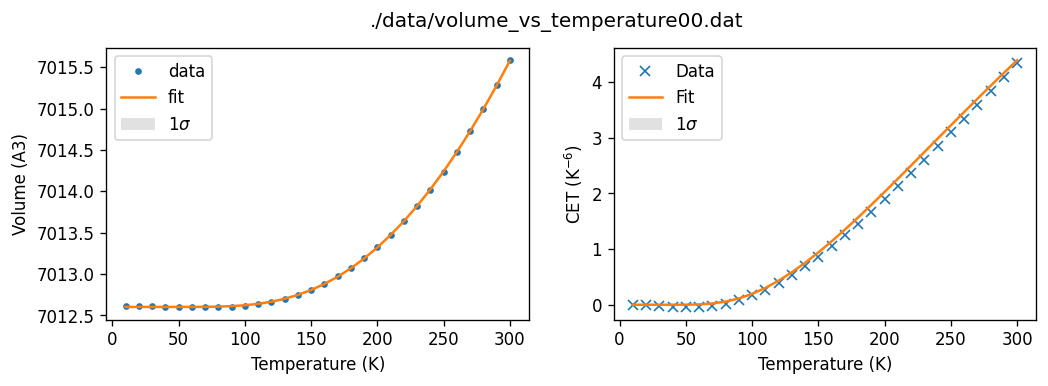

###################### ./data/volume_vs_temperature01.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 30450
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00216409
    reduced chi-square = 8.6564e-05
    Akaike info crit   = -276.108530
    Bayesian info crit = -269.102543
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  7203.76327 +/- 0.00273454 (0.00%) (init = 400)
    a1:  727.818348 +/- 5.75384272 (0.79%) (init = 100)
    a2:  0 (fixed)
    a3:  2999.67006 +/-        nan (nan%) (init = 0)
    a4: -4.01890985 +/- 1.21661219 (30.27%) (init = 0)
    a5:  0.11014749 +/- 0.00207465 (1.88%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a4) =  0.931
    C(a4, a5) = -0.869
    C(a1, a5) = -0.629
    C(a0, a1) =  0.427
    C(a0, a4) =  0.216


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.001953699921614316
---------- DE bounds ----------
a0 :         0	     7203.76	    8000
a1 :         0	     727.818	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     2999.67	    3000
a4 :        -5	    -4.01891	       5
a5 :     1e-05	    0.110147	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0007501032195048972 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.00034713568889067323 < 1e-05 at iteration 121 and prob(a4=-4.994263291359105) = 0.09988805403224289 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00975  -0.00975  -0.009757203.76133  +0.00731  +0.00731  +0.00731
 a1:  -1.03406 -26.23912  -9.16276 674.20005 +26.37917 +50.77448 +59.21845
 a3:-1210.39795-874.51468 -79.678971863.37562+405.92576+1011.04590+1012.31662
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00396  -0.00396  -0.00223   0.10486  +0.00290  +0.00343  +0.00100
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 974
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00168377
    reduced chi-square = 6.7351e-05
    Akaike info crit   = -283.637553
    Bayesian info crit = -276.631566
[[Variables]]
    a0:  7203.76133 +/- 0.00243718 (0.00%) (init = 7203.763)
    a1:  674.200051 +/- 26.2619973 (3.90%) (init = 727.8183)
    a2:  0 (fixed)
    a3:  1863.37562 +/- 506.194257 (27.17%) (init = 2999.67)
    a4: -5.00000000 +/- 4.7411e-05 (0.00%) (in

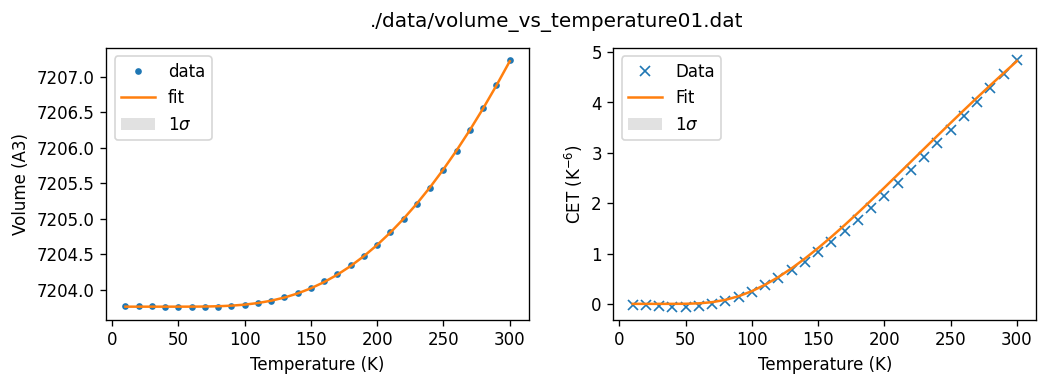

###################### ./data/volume_vs_temperature02.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 31476
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00207615
    reduced chi-square = 8.3046e-05
    Akaike info crit   = -277.353134
    Bayesian info crit = -270.347148
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  7208.54040 +/- 0.00262788 (0.00%) (init = 400)
    a1:  623.803301 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  1043.26723 +/-        nan (nan%) (init = 0)
    a4: -4.50278000 +/- 0.76340200 (16.95%) (init = 0)
    a5:  0.06674314 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.0039770316834619734
---------- DE bounds ----------
a0 :         0	     7208.54	    8000
a1 :         0	     623.803	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     1043.27	    3000
a4 :        -5	    -4.50278	       5
a5 :     1e-05	   0.0667431	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.007260643376630183 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.991963412177166) = 0.15400703466473809 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01023  -0.01023  -0.010237208.54148  +0.00767  +0.00767  +0.00767
 a1: -85.32131 -54.25346 -10.21475 615.52759 +29.51227 +61.27425 +96.67302
 a3:-573.66385-421.82390-223.40843 986.44544+169.22537+180.82170+261.63532
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00154  -0.00182  -0.00146   0.06740  +0.00267  +0.00276  +0.00302
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 499
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00180539
    reduced chi-square = 7.2216e-05
    Akaike info crit   = -281.545270
    Bayesian info crit = -274.539283
[[Variables]]
    a0:  7208.54148 +/- 0.00255716 (0.00%) (init = 7208.54)
    a1:  615.527591 +/- 28.5225015 (4.63%) (init = 623.8033)
    a2:  0 (fixed)
    a3:  986.445443 +/- 262.304794 (26.59%) (init = 1043.267)
    a4: -5.00000000 +/- 3.9983e-05 (0.00%) (init 

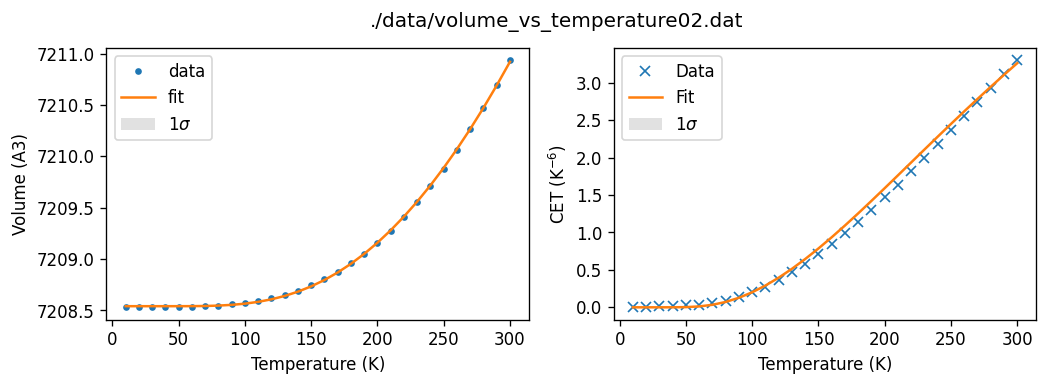

###################### ./data/volume_vs_temperature03.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 40962
    # data points      = 30
    # variables        = 5
    chi-square         = 0.13347375
    reduced chi-square = 0.00533895
    Akaike info crit   = -152.451436
    Bayesian info crit = -145.445449
[[Variables]]
    a0:  7132.80697 +/- 0.02464520 (0.00%) (init = 400)
    a1:  411.881869 +/- 37.2136181 (9.04%) (init = 100)
    a2:  0 (fixed)
    a3:  600.149580 +/- 289.168431 (48.18%) (init = 0)
    a4: -4.97906437 +/- 0.26405325 (5.30%) (init = 0)
    a5:  0.08066230 +/- 0.00603707 (7.48%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5) =  0.972
    C(a1, a3) =  0.933
    C(a3, a5) =  0.850
    C(a0, a5) =  0.225
    C(a0, a1) =  0.146
Cost: 0.009204191298522346
---------- DE bounds ----------
a0 :         0	     7132.81	    8000
a1 :         0	     411.882	    2000
a2 :   

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0005450295726305435 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.994530550447029) = 0.0675277235062743 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.09393  -0.09393  -0.093937132.81434  +0.04697  +0.04697  +0.04697
 a1: -45.04727 -45.03026  -1.59509 469.39450 +47.73689+101.70786+132.98150
 a3:-1049.47043-757.97915-452.610691136.74846+405.52484+540.66440+171.97040
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.02064  -0.01395  -0.00712   0.08996  +0.00752  +0.01448  +0.01455
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 669
    # data points      = 30
    # variables        = 5
    chi-square         = 0.12409125
    reduced chi-square = 0.00496365
    Akaike info crit   = -154.638065
    Bayesian info crit = -147.632079
[[Variables]]
    a0:  7132.81434 +/- 0.02348281 (0.00%) (init = 7132.807)
    a1:  469.394499 +/- 45.0578743 (9.60%) (init = 411.8819)
    a2:  0 (fixed)
    a3:  1136.74846 +/- 548.788150 (48.28%) (init = 600.1496)
    a4: -5.00000000 +/- 2.7211e-05 (0.00%) (ini

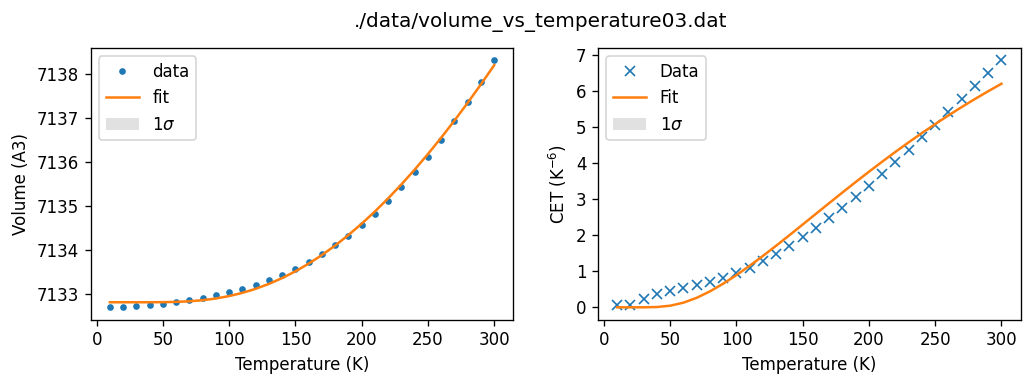

###################### ./data/volume_vs_temperature04.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32184
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00513473
    reduced chi-square = 2.0539e-04
    Akaike info crit   = -250.187785
    Bayesian info crit = -243.181798
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  7185.49646 +/- 0.00500636 (0.00%) (init = 400)
    a1:  579.635159 +/- 10.7813913 (1.86%) (init = 100)
    a2:  0 (fixed)
    a3: -264.272001 +/- 98.2729937 (37.19%) (init = 0)
    a4: -4.53759942 +/-        nan (nan%) (init = 0)
    a5:  0.11358004 +/- 0.00573654 (5.05%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  6.662
    C(a1, a5) =  2.204
    C(a3, a5) =  1.650
    C(a0, a3) = -1.240
    C(a0, a1) = -1.007
    C(a0, a5) = -0.478


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.003960125126468483
---------- DE bounds ----------
a0 :         0	      7185.5	    8000
a1 :         0	     579.635	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -264.272	    3000
a4 :        -5	     -4.5376	       5
a5 :     1e-05	     0.11358	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.03564262012714915 < 1e-05 at iteration 8 and prob(a1=766.9737738887513) = 0.8114008229803685 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00011754742273443833 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.11206378993715012 < 1e-05 at iteration 6 and prob(a4=-4.998642069251861) = 0.009094971593422131 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.02025  -0.02025  -0.020257185.49647  +0.01013  +0.01013  +0.01013
 a1: -61.68716 -41.67550 -21.58365 575.90425 +81.98626      +inf      +inf
 a3:-173.98454-174.72431-141.44920-235.75592+231.54755+275.79767+523.99508
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.01855  -0.01210  -0.00161   0.11360  +0.00017  +0.01506  +0.01758
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1185
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00512525
    reduced chi-square = 2.0501e-04
    Akaike info crit   = -250.243193
    Bayesian info crit = -243.237206
[[Variables]]
    a0:  7185.49647 +/- 0.00506358 (0.00%) (init = 7185.496)
    a1:  575.904247 +/- 23.8836909 (4.15%) (init = 579.6352)
    a2:  0 (fixed)
    a3: -235.755917 +/- 174.923866 (74.20%) (init = -264.272)
    a4: -5.00000000 +/- 2.2632e-04 (0.00%) (ini

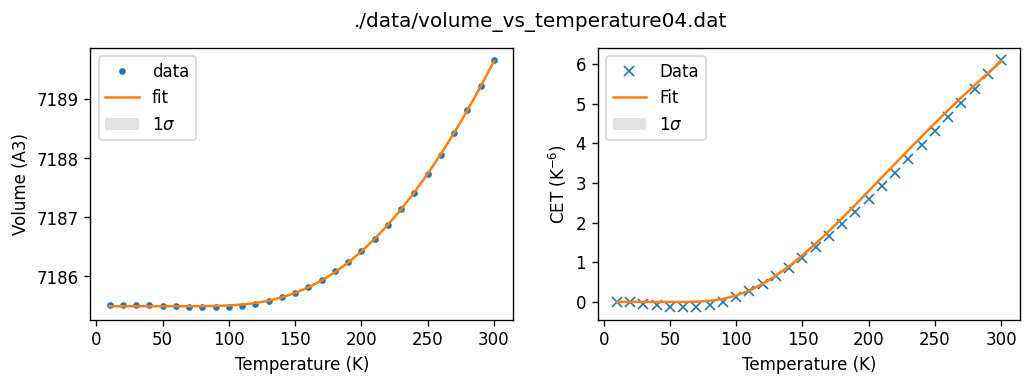

###################### ./data/volume_vs_temperature05.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 43596
    # data points      = 30
    # variables        = 5
    chi-square         = 0.03241123
    reduced chi-square = 0.00129645
    Akaike info crit   = -194.913433
    Bayesian info crit = -187.907446
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  7119.18214 +/- 0.01089119 (0.00%) (init = 400)
    a1:  539.824421 +/- 20.1750478 (3.74%) (init = 100)
    a2:  0 (fixed)
    a3:  1791.92436 +/- 412.529489 (23.02%) (init = 0)
    a4: -3.59109521 +/-        nan (nan%) (init = 0)
    a5:  0.09599268 +/- 8.9845e-04 (0.94%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5) =  5.490
    C(a0, a5) =  2.567
    C(a3, a5) =  2.465
    C(a1, a3) =  1.183
    C(a0, a3) =  0.175
    C(a0, a1) =  0.155


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.005393085116338625
---------- DE bounds ----------
a0 :         0	     7119.18	    8000
a1 :         0	     539.824	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     1791.92	    3000
a4 :        -5	     -3.5911	       5
a5 :     1e-05	   0.0959927	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0003547746076856282 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.5220348840024172 < 1e-05 at iteration 3 and prob(a4=-4.999998939811036) = 0.0015108900960819458 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.04263  -0.04263  -0.042637119.17569  +0.04263  +0.04263  +0.04263
 a1: -91.77990 -60.71759 -30.49459 495.22561 +31.97982 +66.86757 +97.93355
 a3:-876.14099-651.33006-366.984881239.71520+415.39103+415.46706+415.46706
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.01458  -0.00960  -0.00478   0.09264  +0.00488  +0.00992  +0.01520
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 739
    # data points      = 30
    # variables        = 5
    chi-square         = 0.02706233
    reduced chi-square = 0.00108249
    Akaike info crit   = -200.324297
    Bayesian info crit = -193.318310
[[Variables]]
    a0:  7119.17569 +/- 0.01065657 (0.00%) (init = 7119.182)
    a1:  495.225608 +/- 30.7217154 (6.20%) (init = 539.8244)
    a2:  0 (fixed)
    a3:  1239.71520 +/- 415.467055 (33.51%) (init = 1791.924)
    a4: -5.00000000 +/- 3.5340e-07 (0.00%) (init

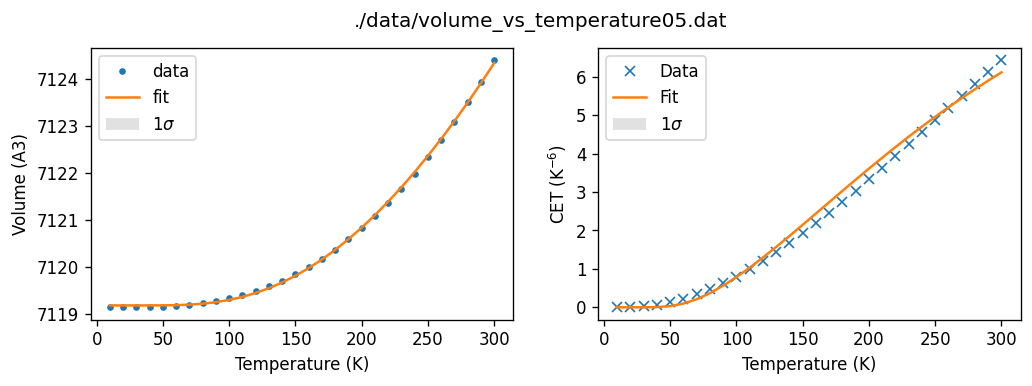

###################### ./data/volume_vs_temperature06.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 31482
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00746662
    reduced chi-square = 2.9866e-04
    Akaike info crit   = -238.955294
    Bayesian info crit = -231.949307
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  7049.78999 +/- 0.00620018 (0.00%) (init = 400)
    a1:  510.485309 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -1620.08357 +/-        nan (nan%) (init = 0)
    a4:  2.33518329 +/-        nan (nan%) (init = 0)
    a5:  0.03928339 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.005181561797144241
---------- DE bounds ----------
a0 :         0	     7049.79	    8000
a1 :         0	     510.485	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -1620.08	    3000
a4 :        -5	     2.33518	       5
a5 :     1e-05	   0.0392834	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00015453587584863225 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.970921308679135) = 0.13186804673196217 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.02364  -0.02364  -0.023647049.79356  +0.01182  +0.01182  +0.01182
 a1:  -4.88511  -6.08012  -1.58137 443.60066  +6.62685  +2.69867 +15.72707
 a3: -56.89851 -56.90691 -11.14217-539.28590  +7.04474 +29.09970 +56.89886
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00389  -0.00019  -0.00009   0.04586  +0.00011  +0.00022  +0.00034
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1250
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00573626
    reduced chi-square = 2.2945e-04
    Akaike info crit   = -246.864354
    Bayesian info crit = -239.858367
[[Variables]]
    a0:  7049.79356 +/- 0.00591114 (0.00%) (init = 7049.79)
    a1:  443.600664 +/- 15.7270669 (3.55%) (init = 510.4853)
    a2:  0 (fixed)
    a3: -539.285904 +/- 57.0520833 (10.58%) (init = -1620.084)
    a4: -4.99999999 +/- 1.4467e-04 (0.00%) (ini

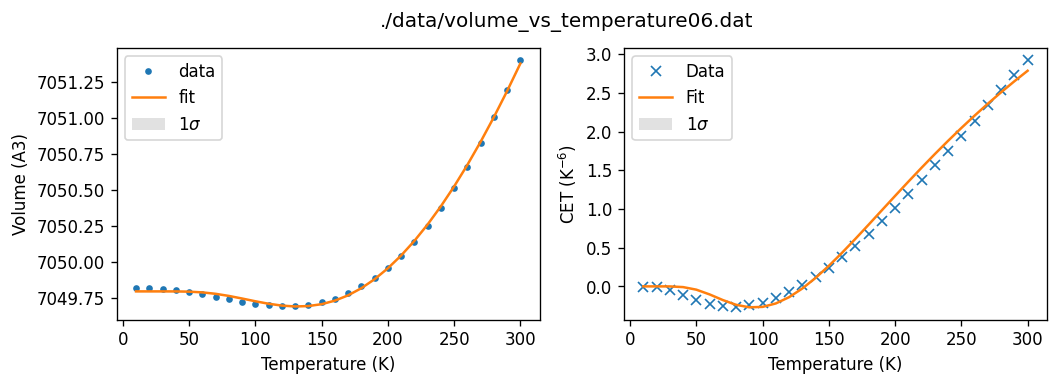

###################### ./data/volume_vs_temperature07.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 36570
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00230525
    reduced chi-square = 9.2210e-05
    Akaike info crit   = -274.212848
    Bayesian info crit = -267.206861
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  7036.85662 +/- 0.00330331 (0.00%) (init = 400)
    a1:  617.073807 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -1121.62712 +/-        nan (nan%) (init = 0)
    a4:  3.38910831 +/-        nan (nan%) (init = 0)
    a5:  0.05227893 +/- 0.00181025 (3.46%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a0, a5) = -1.062


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.004166818568592134
---------- DE bounds ----------
a0 :         0	     7036.86	    8000
a1 :         0	     617.074	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -1121.63	    3000
a4 :        -5	     3.38911	       5
a5 :     1e-05	   0.0522789	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0003771321950268852 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.935489183030115) = 0.13228746538616554 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01271  -0.01271  -0.012717036.85826  +0.00635  +0.00635  +0.00635
 a1: -32.00890 -31.86612  -0.72245 525.12850 +16.57107 +18.07014  +1.88838
 a3: -15.84531  -9.68290  -4.22724-238.36183 +13.62824 +17.53780 +17.65434
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.01139  -0.00525  -0.00214   0.05690  +0.00009  +0.00018  +0.00027
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1676
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00192514
    reduced chi-square = 7.7006e-05
    Akaike info crit   = -279.618634
    Bayesian info crit = -272.612647
[[Variables]]
    a0:  7036.85826 +/- 0.00317739 (0.00%) (init = 7036.857)
    a1:  525.128502 +/- 18.0701435 (3.44%) (init = 617.0738)
    a2:  0 (fixed)
    a3: -238.361833 +/- 21.7119375 (9.11%) (init = -1121.627)
    a4: -4.99999999 +/- 3.2095e-04 (0.01%) (ini

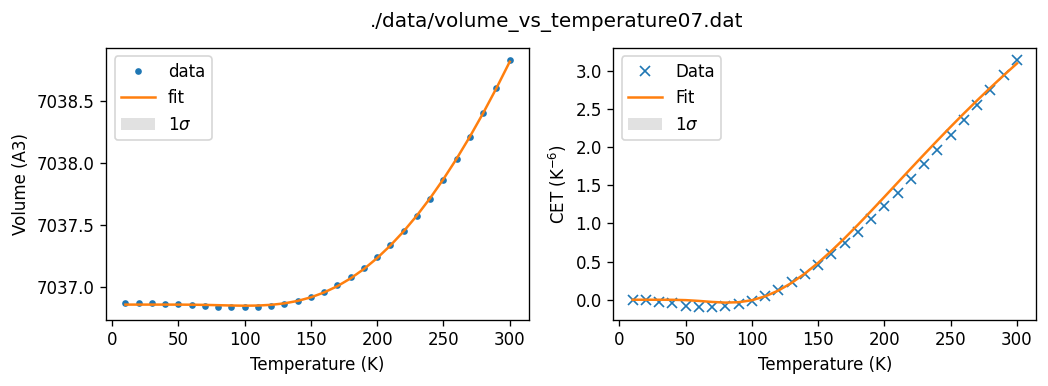

###################### ./data/volume_vs_temperature08.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 30018
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00662407
    reduced chi-square = 2.6496e-04
    Akaike info crit   = -242.547300
    Bayesian info crit = -235.541314
[[Variables]]
    a0:  7072.53145 +/- 0.00540377 (0.00%) (init = 400)
    a1:  643.810567 +/- 47.4355792 (7.37%) (init = 100)
    a2:  0 (fixed)
    a3:  1721.04232 +/- 722.662453 (41.99%) (init = 0)
    a4: -3.68372163 +/- 1.49766568 (40.66%) (init = 0)
    a5:  0.07339501 +/- 0.00478950 (6.53%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.965
    C(a3, a5) =  0.868
    C(a1, a5) =  0.762
    C(a0, a1) =  0.459
    C(a4, a5) = -0.415
    C(a0, a3) =  0.355
    C(a0, a5) =  0.332
    C(a0, a4) =  0.252
    C(a1, a4) =  0.244
Cost: -0.0032904242834774777
---------- DE boun

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.003170048960137267 < 1e-05 at iteration 3 and prob(a0=7072.540657320315) = 0.9940928337832283 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0023301131842965806 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.9816251747787526) = 0.2062833043424411 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01731  -0.01731  -0.017317072.52768  +0.01298  +0.01298      +inf
 a1:  -2.03683 -31.13565 -29.86523 567.52516 +33.11160 +69.16105+109.67311
 a3:-288.51224-258.34386-234.93489 957.88578+201.16818+281.08890 +32.99519
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00046  -0.00352  -0.00097   0.06832  +0.00345  +0.00682  +0.01017
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1087
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00489537
    reduced chi-square = 1.9581e-04
    Akaike info crit   = -251.619887
    Bayesian info crit = -244.613900
[[Variables]]
    a0:  7072.52768 +/- 0.00432635 (0.00%) (init = 7072.531)
    a1:  567.525157 +/- 31.8785668 (5.62%) (init = 643.8106)
    a2:  0 (fixed)
    a3:  957.885779 +/- 288.528977 (30.12%) (init = 1721.042)
    a4: -4.99999999 +/- 9.1417e-05 (0.00%) (ini

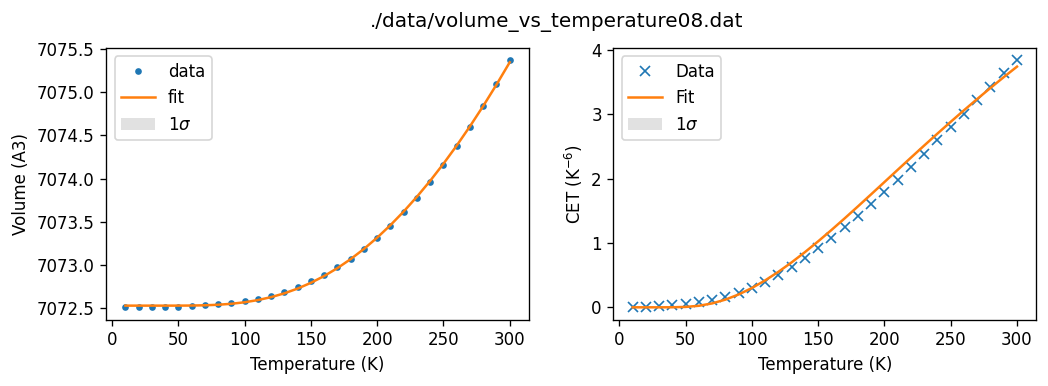

###################### ./data/volume_vs_temperature09.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 36324
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00562086
    reduced chi-square = 2.2483e-04
    Akaike info crit   = -247.474018
    Bayesian info crit = -240.468031
[[Variables]]
    a0:  7096.51032 +/- 0.00589075 (0.00%) (init = 400)
    a1:  493.032781 +/- 33.0383952 (6.70%) (init = 100)
    a2:  0 (fixed)
    a3: -1245.40089 +/- 616.816209 (49.53%) (init = 0)
    a4: -2.71391930 +/- 3.78725262 (139.55%) (init = 0)
    a5:  0.04442251 +/- 0.00416860 (9.38%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -0.991
    C(a1, a3) = -0.955
    C(a1, a4) =  0.913
    C(a4, a5) = -0.877
    C(a3, a5) =  0.807
    C(a1, a5) = -0.609
    C(a0, a1) = -0.466
    C(a0, a3) =  0.309
    C(a0, a4) = -0.272
Cost: 0.005839924084284576
---------- DE bound

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.993094606344686) = 0.06584133520909671 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.02190  -0.02190  -0.021907096.51123  +0.01095  +0.01095  +0.01095
 a1:  -5.79736  -3.75295  -1.91823 473.71226  +1.54642  +3.40952 +13.28777
 a3: -76.71865 -13.07196  -5.89560-874.31324 +50.77838 +62.91380 +22.79830
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00601  -0.00449  -0.00009   0.04655  +0.00012  +0.00023  +0.00037
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 992
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00513758
    reduced chi-square = 2.0550e-04
    Akaike info crit   = -250.171113
    Bayesian info crit = -243.165126
[[Variables]]
    a0:  7096.51123 +/- 0.00547452 (0.00%) (init = 7096.51)
    a1:  473.712261 +/- 13.9062318 (2.94%) (init = 493.0328)
    a2:  0 (fixed)
    a3: -874.313244 +/- 78.6942279 (9.00%) (init = -1245.401)
    a4: -5.00000000 +/- 3.4355e-05 (0.00%) (init 

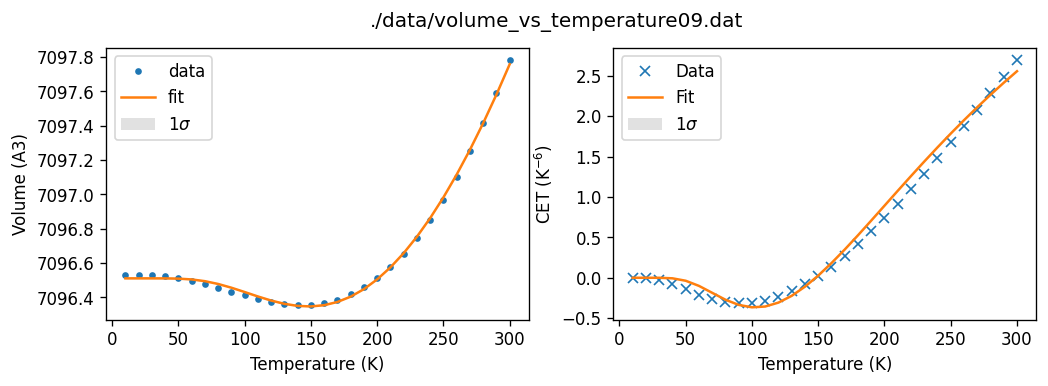

###################### ./data/volume_vs_temperature10.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 30816
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00404967
    reduced chi-square = 1.6199e-04
    Akaike info crit   = -257.309511
    Bayesian info crit = -250.303524
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  7168.47138 +/- 0.00426851 (0.00%) (init = 400)
    a1:  571.729087 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -968.023952 +/-        nan (nan%) (init = 0)
    a4: -0.18126238 +/-        nan (nan%) (init = 0)
    a5:  0.06956379 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.004482014034692838
---------- DE bounds ----------
a0 :         0	     7168.47	    8000
a1 :         0	     571.729	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -968.024	    3000
a4 :        -5	   -0.181262	       5
a5 :     1e-05	   0.0695638	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00594086720563512 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.6719364957903788 < 1e-05 at iteration 4 and prob(a4=-4.999702754837183) = 0.009130583996462955 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01735  -0.01735  -0.017357168.47000  +0.00868  +0.00868  +0.00868
 a1: -20.02240  -7.23498  -0.73637 546.68251 +30.04807+101.29029+120.24845
 a3: -39.91939 -15.01870 -32.80765-434.34524  +8.66523 +16.88689 +26.15872
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00351  -0.00351  -0.00029   0.07514  +0.00013  +0.00028  +0.00655
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1441
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00363709
    reduced chi-square = 1.4548e-04
    Akaike info crit   = -260.533093
    Bayesian info crit = -253.527106
[[Variables]]
    a0:  7168.47000 +/- 0.00433852 (0.00%) (init = 7168.471)
    a1:  546.682514 +/- 20.0591673 (3.67%) (init = 571.7291)
    a2:  0 (fixed)
    a3: -434.345241 +/- 39.9193941 (9.19%) (init = -968.024)
    a4: -5.00000000 +/- 7.4311e-05 (0.00%) (init

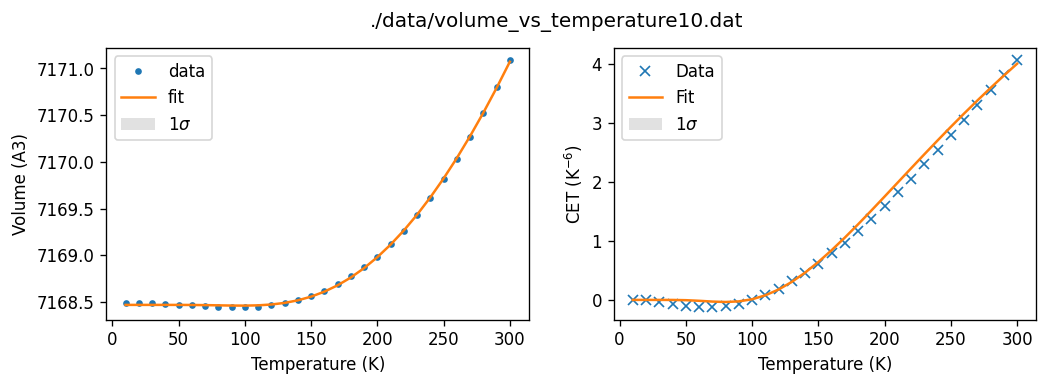

###################### ./data/volume_vs_temperature11.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 27552
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00418316
    reduced chi-square = 1.6733e-04
    Akaike info crit   = -256.336567
    Bayesian info crit = -249.330580
[[Variables]]
    a0:  7097.51914 +/- 0.00502963 (0.00%) (init = 400)
    a1:  483.756938 +/- 27.2972393 (5.64%) (init = 100)
    a2:  0 (fixed)
    a3: -961.899155 +/- 410.582937 (42.68%) (init = 0)
    a4: -3.33542698 +/- 2.50585638 (75.13%) (init = 0)
    a5:  0.04163930 +/- 0.00285158 (6.85%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -0.986
    C(a1, a3) = -0.937
    C(a1, a4) =  0.875
    C(a4, a5) = -0.795
    C(a3, a5) =  0.686
    C(a0, a1) = -0.448
    C(a1, a5) = -0.407
    C(a0, a3) =  0.260
    C(a0, a4) = -0.214
    C(a0, a5) = -0.111
Cost: -0.005897850406654

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00033912107106017744 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.9824128369188925) = 0.11188148009425691 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01907  -0.01907  -0.019077097.51982  +0.00954  +0.00954  +0.00954
 a1:  -5.32949  -3.45272  -1.78334 466.53321  +2.19049  +3.08318 +13.10172
 a3: -30.15793 -10.87433  -4.85277-688.77061  +6.51651+120.78228+121.23625
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00668  -0.00167  -0.00008   0.04304  +0.00027  +0.00088  +0.00030
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 942
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00387852
    reduced chi-square = 1.5514e-04
    Akaike info crit   = -258.604953
    Bayesian info crit = -251.598967
[[Variables]]
    a0:  7097.51982 +/- 0.00476815 (0.00%) (init = 7097.519)
    a1:  466.533206 +/- 13.5845926 (2.91%) (init = 483.7569)
    a2:  0 (fixed)
    a3: -688.770609 +/- 65.5357206 (9.51%) (init = -961.8992)
    a4: -5.00000000 +/- 8.7498e-05 (0.00%) (init

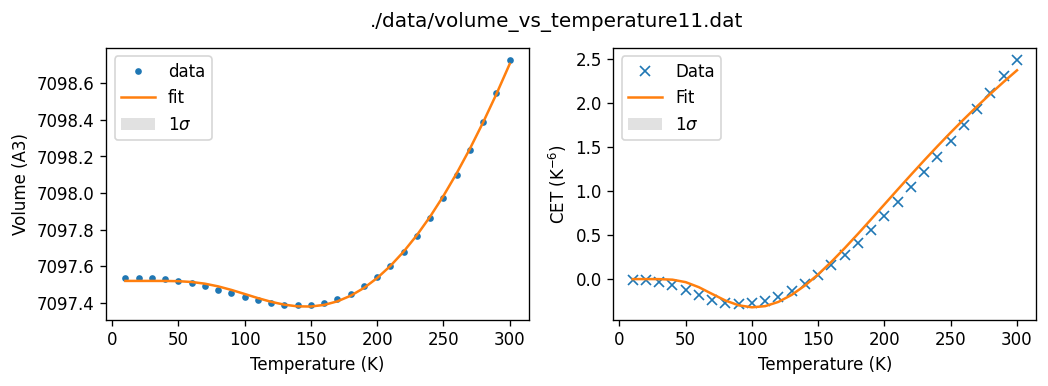

###################### ./data/volume_vs_temperature12.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 30888
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00180762
    reduced chi-square = 7.2305e-05
    Akaike info crit   = -281.508305
    Bayesian info crit = -274.502318
[[Variables]]
    a0:  7123.56270 +/- 0.00272364 (0.00%) (init = 400)
    a1:  739.751035 +/- 44.5908934 (6.03%) (init = 100)
    a2:  0 (fixed)
    a3:  2683.75693 +/- 1438.41160 (53.60%) (init = 0)
    a4: -1.83936334 +/- 3.48911968 (189.69%) (init = 0)
    a5:  0.09958776 +/- 0.01015803 (10.20%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.962
    C(a3, a5) =  0.915
    C(a4, a5) = -0.897
    C(a1, a5) =  0.779
    C(a3, a4) = -0.657
    C(a1, a4) = -0.430
    C(a0, a1) =  0.344
    C(a0, a3) =  0.218
    C(a0, a4) =  0.160
Cost: -0.002032076868999866
---------- DE bou

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a3=3000) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00943  -0.00943  -0.009437123.56164  +0.00943  +0.00943  +0.00943
 a1:-181.23133 -93.86277 -32.01389 736.36932  +8.10640 +20.61256 +35.50853
 a3:-2715.48691-1949.67277-766.409582982.17569      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.99547  +1.70909  +5.25891  +9.54025
 a5:  -0.02589  -0.01568  -0.00497   0.10556  +0.00105  +0.00208  +0.00325
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 934
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00165511
    reduced chi-square = 6.6205e-05
    Akaike info crit   = -284.152500
    Bayesian info crit = -277.146513
[[Variables]]
    a0:  7123.56164 +/- 0.00235827 (0.00%) (init = 7123.563)
    a1:  736.369320 +/- 11.5860709 (1.57%) (init = 739.751)
    a2:  0 (fixed)
    a3:  2982.17569 +/- 300.767364 (10.09%) (init = 2683.757)
    a4: -4.99547047 +/- 0.22060417 (4.42%) (ini

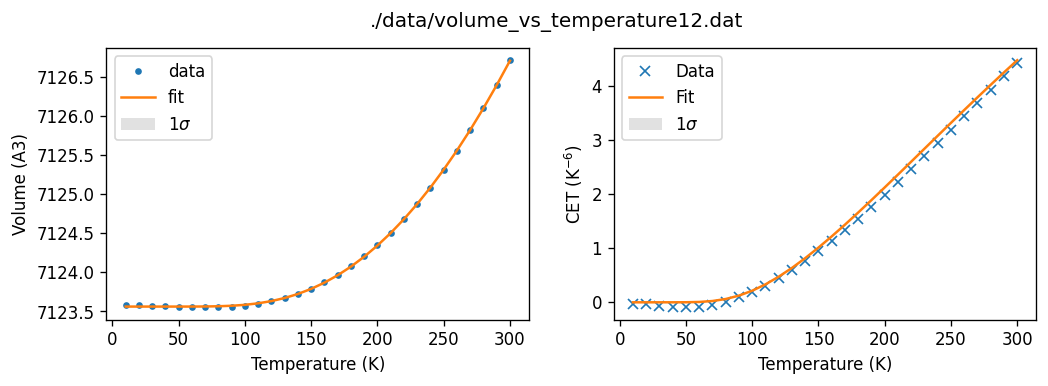

###################### ./data/volume_vs_temperature13.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33978
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00392983
    reduced chi-square = 1.5719e-04
    Akaike info crit   = -258.210707
    Bayesian info crit = -251.204720
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  7138.35588 +/- 0.00442877 (0.00%) (init = 400)
    a1:  576.512433 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -1300.99942 +/-        nan (nan%) (init = 0)
    a4:  3.96058086 +/-        nan (nan%) (init = 0)
    a5:  0.05675101 +/- 0.00177878 (3.13%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a0, a5) = -1.044


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.005073323139185959
---------- DE bounds ----------
a0 :         0	     7138.36	    8000
a1 :         0	     576.512	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	       -1301	    3000
a4 :        -5	     3.96058	       5
a5 :     1e-05	    0.056751	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=5) = 0.9828766277520181 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01677  -0.01677  -0.016777138.35816  +0.01677  +0.01677  +0.01677
 a1: -48.36988 -32.19734 -16.81834 492.98124 +23.19005 +72.37963+131.48022
 a3:-1163.70728-744.35093-199.84516-343.75117 +28.27116 +55.59424 +97.13834
 a4:      -inf      -inf      -inf  -4.96726  +1.75204  +6.80993      +inf
 a5:  -0.01162  -0.00531  -0.00236   0.06236  +0.00250  +0.00556  +0.00962
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1085
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00318512
    reduced chi-square = 1.2740e-04
    Akaike info crit   = -264.513905
    Bayesian info crit = -257.507918
[[Variables]]
    a0:  7138.35816 +/- 0.00419175 (0.00%) (init = 7138.356)
    a1:  492.981240 +/- 16.9668855 (3.44%) (init = 576.5124)
    a2:  0 (fixed)
    a3: -343.751172 +/- 56.3294799 (16.39%) (init = -1300.999)
    a4: -4.96725694 +/- 0.44334501 (8.93%) (i

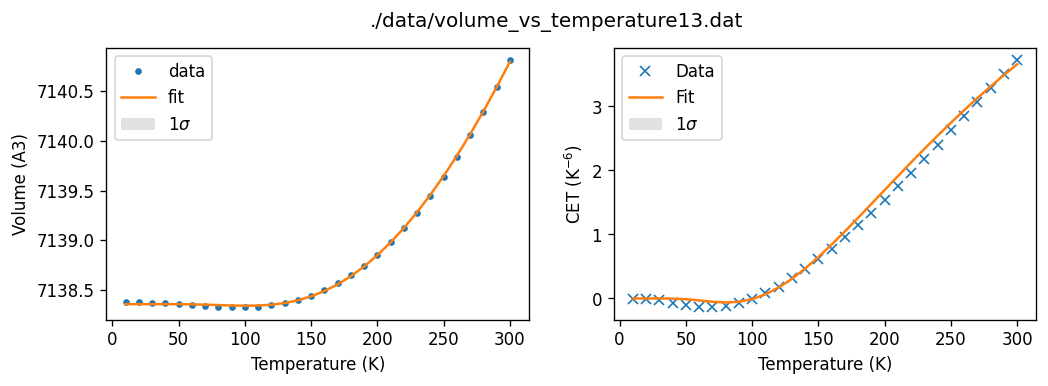

###################### ./data/volume_vs_temperature14.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32712
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00175532
    reduced chi-square = 7.0213e-05
    Akaike info crit   = -282.389027
    Bayesian info crit = -275.383040
[[Variables]]
    a0:  7016.63756 +/- 0.00322605 (0.00%) (init = 400)
    a1:  522.171706 +/- 41.6473981 (7.98%) (init = 100)
    a2:  0 (fixed)
    a3: -697.861326 +/- 469.782279 (67.32%) (init = 0)
    a4: -2.29943205 +/- 3.25731916 (141.66%) (init = 0)
    a5:  0.03927667 +/- 0.00295061 (7.51%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -0.997
    C(a1, a3) = -0.962
    C(a1, a4) =  0.944
    C(a4, a5) = -0.853
    C(a3, a5) =  0.814
    C(a1, a5) = -0.635
    C(a0, a1) = -0.450
    C(a0, a3) =  0.306
    C(a0, a4) = -0.296
Cost: -0.004841553472033411
---------- DE boun

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.000571677897005412 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.9984182029659925) = 0.03179649190985295 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01175  -0.01175  -0.011757016.63823  +0.01175  +0.01175  +0.01175
 a1: -28.85390 -28.24899 -13.48471 484.78405 +18.38118 +28.51750 +28.87318
 a3:-175.10126-175.34396-143.17527-300.43178 +13.68656 +19.53771+104.94265
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00145  -0.00145  -0.00104   0.04106  +0.00038  +0.00139  +0.00145
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1422
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00155387
    reduced chi-square = 6.2155e-05
    Akaike info crit   = -286.046146
    Bayesian info crit = -279.040159
[[Variables]]
    a0:  7016.63823 +/- 0.00293735 (0.00%) (init = 7016.638)
    a1:  484.784054 +/- 14.4430094 (2.98%) (init = 522.1717)
    a2:  0 (fixed)
    a3: -300.431782 +/- 35.0687927 (11.67%) (init = -697.8613)
    a4: -5.00000000 +/- 7.8696e-06 (0.00%) (in

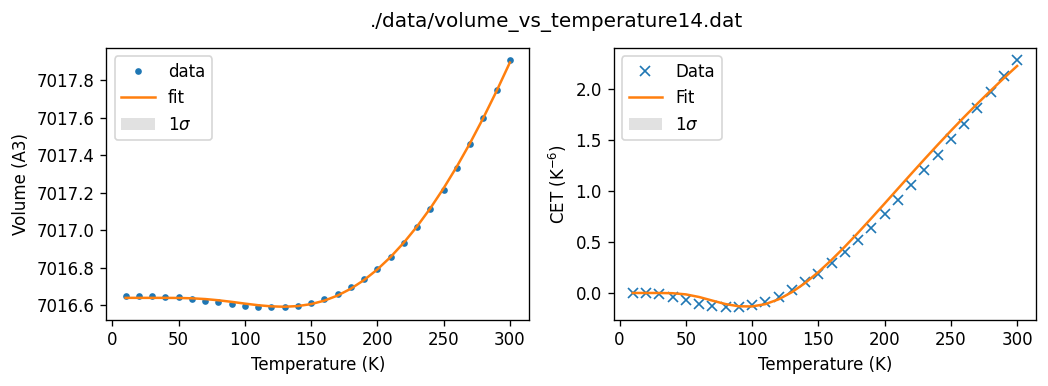

###################### ./data/volume_vs_temperature15.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 36300
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00474135
    reduced chi-square = 1.8965e-04
    Akaike info crit   = -252.578900
    Bayesian info crit = -245.572913
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  7041.51150 +/- 0.00484342 (0.00%) (init = 400)
    a1:  545.277562 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -1724.65814 +/-        nan (nan%) (init = 0)
    a4:  2.47883420 +/-        nan (nan%) (init = 0)
    a5:  0.04225687 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.005326224592863582
---------- DE bounds ----------
a0 :         0	     7041.51	    8000
a1 :         0	     545.278	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -1724.66	    3000
a4 :        -5	     2.47883	       5
a5 :     1e-05	   0.0422569	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00015361989978292462 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.9893313055869895) = 0.07868687243389104 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01825  -0.01825  -0.018257041.51404  +0.00912  +0.00912  +0.00912
 a1: -14.52990  -2.57019  -1.33326 482.20718  +1.09017 +26.07493 +28.91002
 a3: -52.08880 -11.29394 -37.64003-627.02399  +7.19080 +12.99734 +20.06386
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00383  -0.00367  -0.00008   0.04903  +0.00011  +0.00163  +0.00031
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1348
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00365537
    reduced chi-square = 1.4621e-04
    Akaike info crit   = -260.382669
    Bayesian info crit = -253.376682
[[Variables]]
    a0:  7041.51404 +/- 0.00456148 (0.00%) (init = 7041.512)
    a1:  482.207179 +/- 14.5298996 (3.01%) (init = 545.2776)
    a2:  0 (fixed)
    a3: -627.023987 +/- 54.5964479 (8.71%) (init = -1724.658)
    a4: -5.00000000 +/- 5.3078e-05 (0.00%) (ini

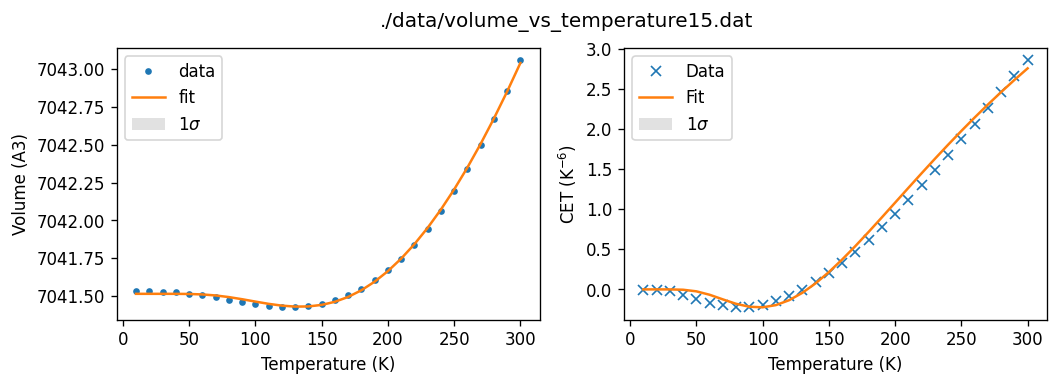

###################### ./data/volume_vs_temperature16.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34872
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00115973
    reduced chi-square = 4.6389e-05
    Akaike info crit   = -294.822919
    Bayesian info crit = -287.816932
[[Variables]]
    a0:  7212.34000 +/- 0.00229123 (0.00%) (init = 400)
    a1:  850.794436 +/- 26.9963826 (3.17%) (init = 100)
    a2:  0 (fixed)
    a3:  2937.84336 +/- 1033.76906 (35.19%) (init = 0)
    a4:  3.40766664 +/- 7.54015501 (221.27%) (init = 0)
    a5:  0.09215430 +/- 0.01432653 (15.55%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.985
    C(a3, a5) =  0.718
    C(a3, a4) = -0.605
    C(a0, a4) =  0.553
    C(a1, a3) =  0.524
    C(a0, a5) = -0.484
    C(a0, a1) =  0.407
    C(a1, a4) =  0.356
    C(a1, a5) = -0.202
    C(a0, a3) = -0.190
Cost: 0.00197554323949

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.037621349060264556 < 1e-05 at iteration 9 and prob(a3=2997.793351399658) = 0.0341096032529417 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a3=3000) = 0.017021502890616894 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00412  -0.00412  -0.004127212.33968  +0.00823  +0.00823  +0.00823
 a1:-302.98051-270.90288 -32.54259 846.69266  +2.83603  +1.94181 +16.03911
 a3:      -inf      -inf      -inf2999.99999      +inf      +inf      +inf
 a4:  -0.23551  -0.10867  -0.05065   1.85042  +0.32882  +0.17610  +0.22206
 a5:  -0.01029  -0.00161  -0.00019   0.09484  +0.00022  +0.01187  +0.01384
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 921
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00115192
    reduced chi-square = 4.6077e-05
    Akaike info crit   = -295.025732
    Bayesian info crit = -288.019745
[[Variables]]
    a0:  7212.33968 +/- 0.00205797 (0.00%) (init = 7212.34)
    a1:  846.692656 +/- 16.0852160 (1.90%) (init = 850.7944)
    a2:  0 (fixed)
    a3:  2999.99999 +/- 0.24518178 (0.01%) (init = 2937.843)
    a4:  1.85041908 +/- 4.07571896 (220.26%) (init

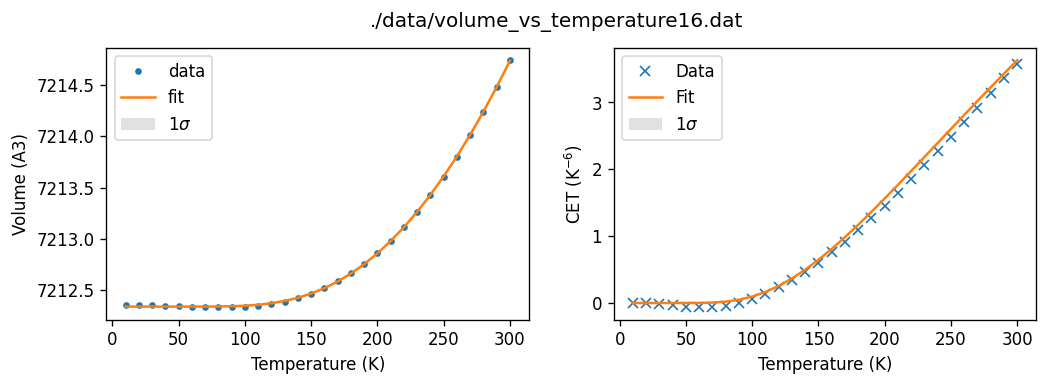

###################### ./data/volume_vs_temperature17.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33066
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00666708
    reduced chi-square = 2.6668e-04
    Akaike info crit   = -242.353102
    Bayesian info crit = -235.347115
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  7147.39332 +/- 0.00580387 (0.00%) (init = 400)
    a1:  531.670287 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -1767.15021 +/-        nan (nan%) (init = 0)
    a4:  2.45691746 +/-        nan (nan%) (init = 0)
    a5:  0.04062692 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.005545510010961152
---------- DE bounds ----------
a0 :         0	     7147.39	    8000
a1 :         0	      531.67	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -1767.15	    3000
a4 :        -5	     2.45692	       5
a5 :     1e-05	   0.0406269	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00018985243353655503 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.969797727582027) = 0.12826017163174835 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.02215  -0.02215  -0.022157147.39630  +0.01108  +0.01108  +0.01108
 a1:  -4.86591  -3.14354  -1.62050 469.03276 +10.58488 +15.56849  +5.85049
 a3: -27.17868 -45.38623 -34.47705-649.11208  +7.49109 +14.56601 +22.55016
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00209  -0.00198  -0.00009   0.04754  +0.00012  +0.00093  +0.00036
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1230
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00523444
    reduced chi-square = 2.0938e-04
    Akaike info crit   = -249.610763
    Bayesian info crit = -242.604776
[[Variables]]
    a0:  7147.39630 +/- 0.00553811 (0.00%) (init = 7147.393)
    a1:  469.032759 +/- 16.0173669 (3.41%) (init = 531.6703)
    a2:  0 (fixed)
    a3: -649.112075 +/- 65.4931767 (10.09%) (init = -1767.15)
    a4: -5.00000000 +/- 1.5026e-04 (0.00%) (ini

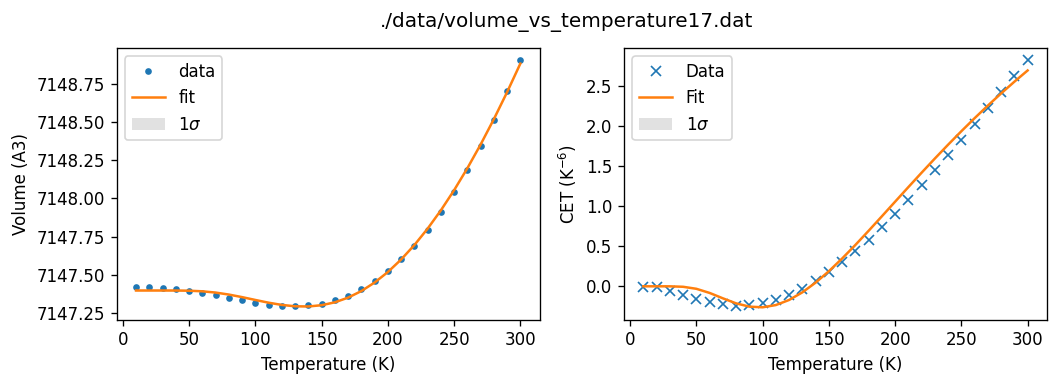

###################### ./data/volume_vs_temperature18.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 38016
    # data points      = 30
    # variables        = 5
    chi-square         = 0.01032610
    reduced chi-square = 4.1304e-04
    Akaike info crit   = -229.228350
    Bayesian info crit = -222.222363
[[Variables]]
    a0:  7058.90704 +/- 0.00666334 (0.00%) (init = 400)
    a1:  543.840178 +/- 33.6496450 (6.19%) (init = 100)
    a2:  0 (fixed)
    a3:  865.705638 +/- 287.500950 (33.21%) (init = 0)
    a4: -3.72770059 +/- 1.43657729 (38.54%) (init = 0)
    a5:  0.06618260 +/- 0.00370870 (5.60%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a5) =  0.895
    C(a1, a3) =  0.824
    C(a1, a5) =  0.653
    C(a1, a4) =  0.428
    C(a4, a5) = -0.382
    C(a0, a4) =  0.308
    C(a0, a1) =  0.307
    C(a0, a5) =  0.133
    C(a3, a4) = -0.129
Cost: -0.005860191829924588
---------- DE bound

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0005059891515210843 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.984090026810117) = 0.18441579688430124 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.02372  -0.02372  -0.023727058.90435  +0.01779  +0.01779  +0.01779
 a1:  -9.16011  -1.54013  -0.88837 529.98126 +35.38331 +74.11298+117.99838
 a3: -78.83230-289.03343-111.49652 905.53193+261.87251+576.53039+228.15904
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00376  -0.00375  -0.00227   0.06718  +0.00258  +0.00375  +0.00376
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 752
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00875977
    reduced chi-square = 3.5039e-04
    Akaike info crit   = -234.163484
    Bayesian info crit = -227.157497
[[Variables]]
    a0:  7058.90435 +/- 0.00592943 (0.00%) (init = 7058.907)
    a1:  529.981256 +/- 33.9062056 (6.40%) (init = 543.8402)
    a2:  0 (fixed)
    a3:  905.531930 +/- 289.135680 (31.93%) (init = 865.7056)
    a4: -4.99999999 +/- 7.9154e-05 (0.00%) (init

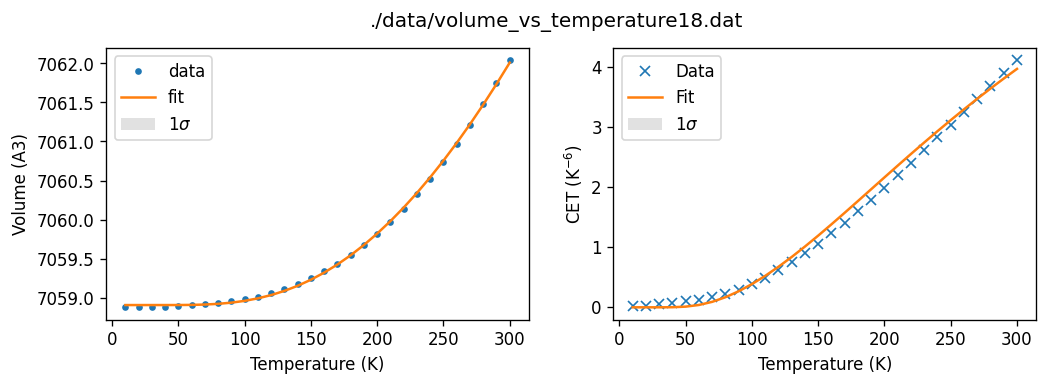

###################### ./data/volume_vs_temperature19.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34494
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00375693
    reduced chi-square = 1.5028e-04
    Akaike info crit   = -259.560542
    Bayesian info crit = -252.554555
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  7087.92171 +/- 0.00426988 (0.00%) (init = 400)
    a1:  588.469930 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -1446.60501 +/-        nan (nan%) (init = 0)
    a4:  3.66981541 +/-        nan (nan%) (init = 0)
    a5:  0.05463328 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.004912879534458625
---------- DE bounds ----------
a0 :         0	     7087.92	    8000
a1 :         0	      588.47	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -1446.61	    3000
a4 :        -5	     3.66982	       5
a5 :     1e-05	   0.0546333	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0019482908381238614 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.978482462434603) = 0.0867940135481083 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01629  -0.01629  -0.016297087.92381  +0.00814  +0.00814  +0.00814
 a1: -31.76662 -31.54041 -10.75085 510.39187  +2.68902 +70.60361+127.05440
 a3: -22.14068 -11.64476  -5.17371-427.36092  +6.98995 +27.12508 +20.91635
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00490  -0.00468  -0.00236   0.06054  +0.00157  +0.00157  +0.00065
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1756
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00306856
    reduced chi-square = 1.2274e-04
    Akaike info crit   = -265.632311
    Bayesian info crit = -258.626324
[[Variables]]
    a0:  7087.92381 +/- 0.00407166 (0.00%) (init = 7087.922)
    a1:  510.391869 +/- 16.7725879 (3.29%) (init = 588.4699)
    a2:  0 (fixed)
    a3: -427.360919 +/- 27.4619921 (6.43%) (init = -1446.605)
    a4: -5.00000000 +/- 1.0705e-04 (0.00%) (ini

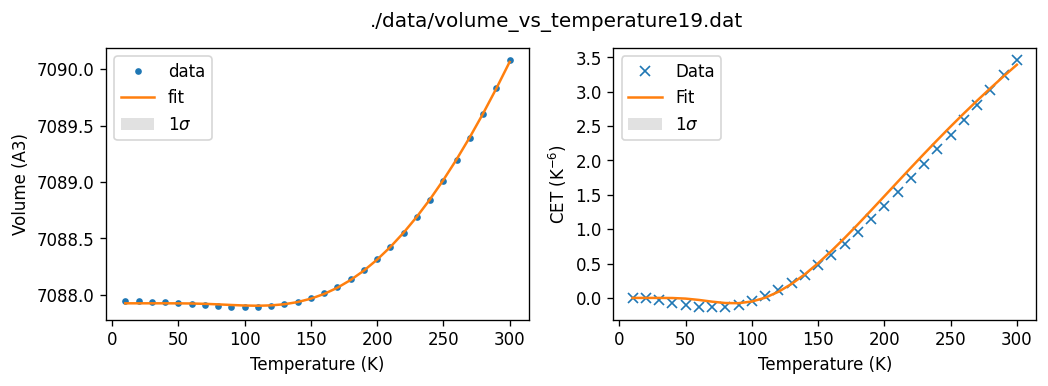

###################### ./data/volume_vs_temperature20.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34470
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00311670
    reduced chi-square = 1.2467e-04
    Akaike info crit   = -265.165312
    Bayesian info crit = -258.159325
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  7075.31526 +/- 0.00378053 (0.00%) (init = 400)
    a1:  559.367728 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -1179.94050 +/-        nan (nan%) (init = 0)
    a4:  2.40207598 +/-        nan (nan%) (init = 0)
    a5:  0.03820832 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.004935347128594003
---------- DE bounds ----------
a0 :         0	     7075.32	    8000
a1 :         0	     559.368	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -1179.94	    3000
a4 :        -5	     2.40208	       5
a5 :     1e-05	   0.0382083	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.944985949141862) = 0.15436523085929052 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01491  -0.01491  -0.014917075.31754  +0.00746  +0.00746  +0.00746
 a1:  -5.69764  -2.02120  -1.06545 468.28151 +22.03399 +42.11431 +69.74891
 a3: -13.95251  -8.51925  -3.70109-215.81246  +5.33554 +10.15089 +18.79212
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00090  -0.00180  -0.00057   0.04347  +0.00008  +0.00016  +0.00025
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1523
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00243707
    reduced chi-square = 9.7483e-05
    Akaike info crit   = -272.544679
    Bayesian info crit = -265.538692
[[Variables]]
    a0:  7075.31754 +/- 0.00372814 (0.00%) (init = 7075.315)
    a1:  468.281507 +/- 17.6062118 (3.76%) (init = 559.3677)
    a2:  0 (fixed)
    a3: -215.812458 +/- 30.0665087 (13.93%) (init = -1179.941)
    a4: -4.99999999 +/- 2.7370e-04 (0.01%) (in

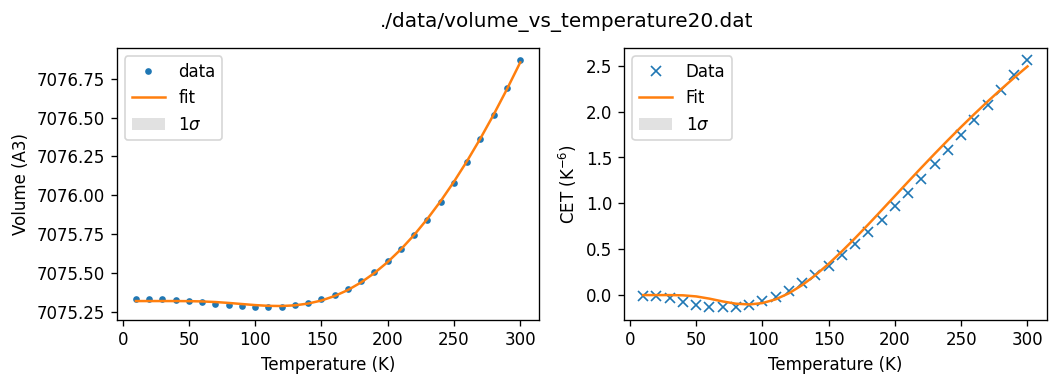

###################### ./data/volume_vs_temperature21.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33450
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00308216
    reduced chi-square = 1.2329e-04
    Akaike info crit   = -265.499627
    Bayesian info crit = -258.493640
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  7073.11905 +/- 0.00320063 (0.00%) (init = 400)
    a1:  731.661109 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  2970.77658 +/-        nan (nan%) (init = 0)
    a4: -4.99658506 +/- 0.06942895 (1.39%) (init = 0)
    a5:  0.08578842 +/- 0.00110870 (1.29%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a0, a5) =  0.500
    C(a4, a5) = -0.102


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.002163163627301401
---------- DE bounds ----------
a0 :         0	     7073.12	    8000
a1 :         0	     731.661	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     2970.78	    3000
a4 :        -5	    -4.99659	       5
a5 :     1e-05	   0.0857884	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.05699622043204137 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.36999091993551825 < 1e-05 at iteration 3 and prob(a4=-4.999610328178571) = 0.0352425005771824 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01013  -0.01013  -0.010137073.11560  +0.00760  +0.00760  +0.00760
 a1:  -1.36699  -5.77726  -0.51046 619.78633 +25.87681 +56.08026 +88.31203
 a3:-643.65408-460.74204  -6.345281107.97659 +96.62464 +16.88470+263.31030
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00958  -0.00626  -0.00011   0.07480  +0.00012  +0.00304  +0.00037
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1226
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00178083
    reduced chi-square = 7.1233e-05
    Akaike info crit   = -281.956154
    Bayesian info crit = -274.950167
[[Variables]]
    a0:  7073.11560 +/- 0.00253274 (0.00%) (init = 7073.119)
    a1:  619.786332 +/- 26.1856890 (4.22%) (init = 731.6611)
    a2:  0 (fixed)
    a3:  1107.97659 +/- 284.214614 (25.65%) (init = 2970.777)
    a4: -4.99999998 +/- 1.2988e-04 (0.00%) (ini

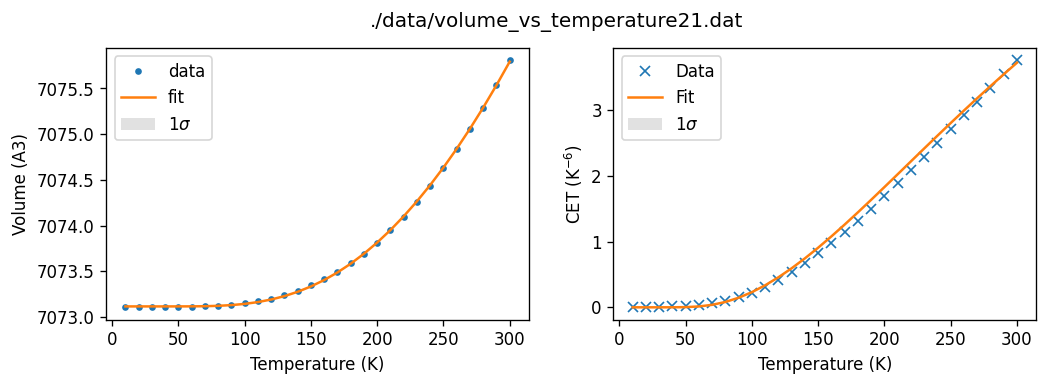

###################### ./data/volume_vs_temperature22.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34392
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00865916
    reduced chi-square = 3.4637e-04
    Akaike info crit   = -234.510049
    Bayesian info crit = -227.504062
[[Variables]]
    a0:  7037.13549 +/- 0.00583986 (0.00%) (init = 400)
    a1:  667.633966 +/- 52.4880977 (7.86%) (init = 100)
    a2:  0 (fixed)
    a3:  2316.45286 +/- 1222.58905 (52.78%) (init = 0)
    a4: -4.78366825 +/- 0.65163217 (13.62%) (init = 0)
    a5:  0.11495519 +/- 0.00832391 (7.24%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.995
    C(a1, a5) =  0.977
    C(a3, a5) =  0.973
    C(a0, a5) =  0.430
    C(a0, a1) =  0.391
    C(a0, a3) =  0.344
Cost: 0.0024651262365296134
---------- DE bounds ----------
a0 :         0	     7037.14	    8000
a1 :         0	    

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.001476003521948795 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.980312212026681) = 0.1586410701779578 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.02149  -0.02149  -0.021497037.13428  +0.01075  +0.01075  +0.01075
 a1: -15.27699  -4.53956 -13.44834 634.28914 +31.74745 +62.16656 +75.54845
 a3:-1215.68750-897.56895-501.567941651.03510 +23.53318 +35.14198+561.65919
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.01673  -0.01095  -0.00023   0.10992  +0.00026  +0.00317  +0.00534
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 643
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00816043
    reduced chi-square = 3.2642e-04
    Akaike info crit   = -236.289656
    Bayesian info crit = -229.283669
[[Variables]]
    a0:  7037.13428 +/- 0.00537276 (0.00%) (init = 7037.135)
    a1:  634.289136 +/- 30.6405060 (4.83%) (init = 667.634)
    a2:  0 (fixed)
    a3:  1651.03510 +/- 562.084237 (34.04%) (init = 2316.453)
    a4: -5.00000000 +/- 9.7949e-05 (0.00%) (init

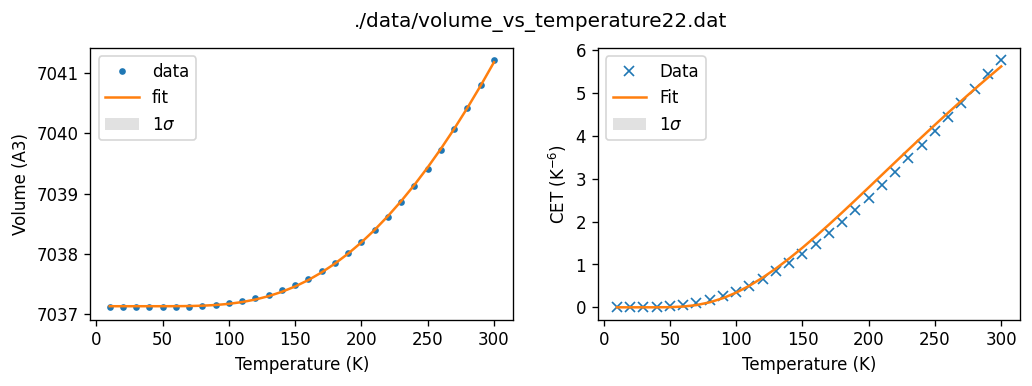

###################### ./data/volume_vs_temperature23.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33852
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00357047
    reduced chi-square = 1.4282e-04
    Akaike info crit   = -261.087705
    Bayesian info crit = -254.081718
[[Variables]]
    a0:  7142.81685 +/- 0.00402152 (0.00%) (init = 400)
    a1:  602.824860 +/- 25.1793003 (4.18%) (init = 100)
    a2:  0 (fixed)
    a3: -912.760560 +/- 230.434170 (25.25%) (init = 0)
    a4:  3.39462789 +/- 2.37463993 (69.95%) (init = 0)
    a5:  0.06995295 +/- 0.00417352 (5.97%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -0.840
    C(a3, a5) =  0.836
    C(a1, a4) =  0.616
    C(a4, a5) = -0.506
    C(a0, a3) = -0.379
    C(a0, a5) = -0.373
    C(a1, a5) =  0.360
    C(a0, a1) = -0.344
    C(a1, a3) = -0.116
Cost: 0.004695890369475819
---------- DE bounds

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0015806518564721705 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.32612019968043465 < 1e-05 at iteration 5 and prob(a4=-4.99904085424625) = 0.013125235703916674 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01629  -0.01629  -0.016297142.81731  +0.01221  +0.01221  +0.01221
 a1: -18.58819 -18.19522 -11.88190 518.10956  +2.50707 +18.50718 +18.62311
 a3: -47.16944 -20.64956  -5.41474-224.44312  +7.27125 +14.02616 +21.68860
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00076  -0.00133  -0.00009   0.07270  +0.00011  +0.00022  +0.00303
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 2034
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00312576
    reduced chi-square = 1.2503e-04
    Akaike info crit   = -265.078259
    Bayesian info crit = -258.072272
[[Variables]]
    a0:  7142.81731 +/- 0.00407166 (0.00%) (init = 7142.817)
    a1:  518.109560 +/- 18.6231113 (3.59%) (init = 602.8249)
    a2:  0 (fixed)
    a3: -224.443123 +/- 47.3864038 (21.11%) (init = -912.7606)
    a4: -5.00000000 +/- 1.9183e-04 (0.00%) (in

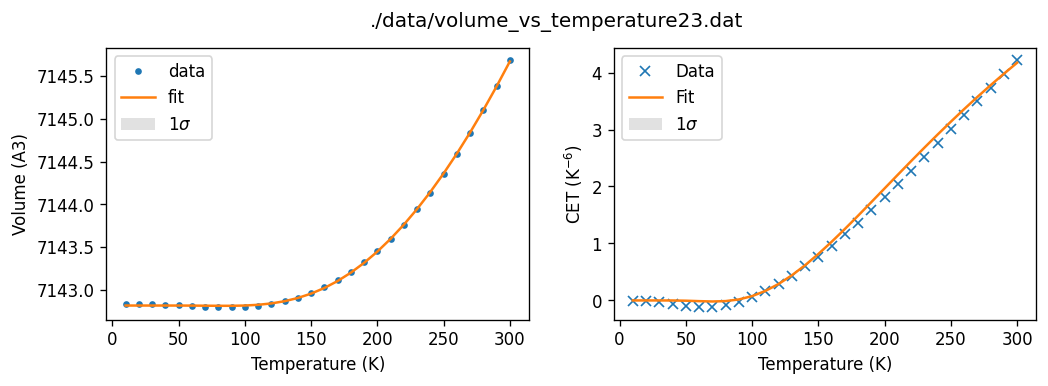

###################### ./data/volume_vs_temperature24.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 26484
    # data points      = 30
    # variables        = 5
    chi-square         = 0.02138033
    reduced chi-square = 8.5521e-04
    Akaike info crit   = -207.394446
    Bayesian info crit = -200.388459
[[Variables]]
    a0:  7155.13461 +/- 0.00888324 (0.00%) (init = 400)
    a1:  623.301178 +/- 38.4763630 (6.17%) (init = 100)
    a2:  0 (fixed)
    a3:  2431.67316 +/- 1065.05255 (43.80%) (init = 0)
    a4: -4.99439944 +/- 0.12407591 (2.48%) (init = 0)
    a5:  0.14812348 +/- 0.00872843 (5.89%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.994
    C(a1, a5) =  0.985
    C(a3, a5) =  0.961
    C(a0, a5) =  0.321
    C(a0, a1) =  0.253
    C(a0, a3) =  0.187
Cost: -0.000502352957482799
---------- DE bounds ----------
a0 :         0	     7155.13	    8000
a1 :         0	     

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a3=3000) = 0.7963939419558845 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.000513016646796871 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.995102036736332) = 0.066465911111492 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.03504  -0.03504  -0.035047155.13415  +0.02628  +0.02628  +0.02628
 a1: -92.13284 -60.91109 -23.57650 612.76716 +23.82430 +39.50141 +55.63882
 a3:-1696.72451-1253.43173-701.155192150.47032+735.94994      +inf      +inf
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.02254  -0.01468  -0.00729   0.14579  +0.00359  +0.00379  +0.00420
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 560
    # data points      = 30
    # variables        = 5
    chi-square         = 0.02127398
    reduced chi-square = 8.5096e-04
    Akaike info crit   = -207.544035
    Bayesian info crit = -200.538048
[[Variables]]
    a0:  7155.13415 +/- 0.00876021 (0.00%) (init = 7155.135)
    a1:  612.767158 +/- 30.7288512 (5.01%) (init = 623.3012)
    a2:  0 (fixed)
    a3:  2150.47032 +/- 788.060688 (36.65%) (init = 2431.673)
    a4: -5.00000000 +/- 2.4368e-05 (0.00%) (in

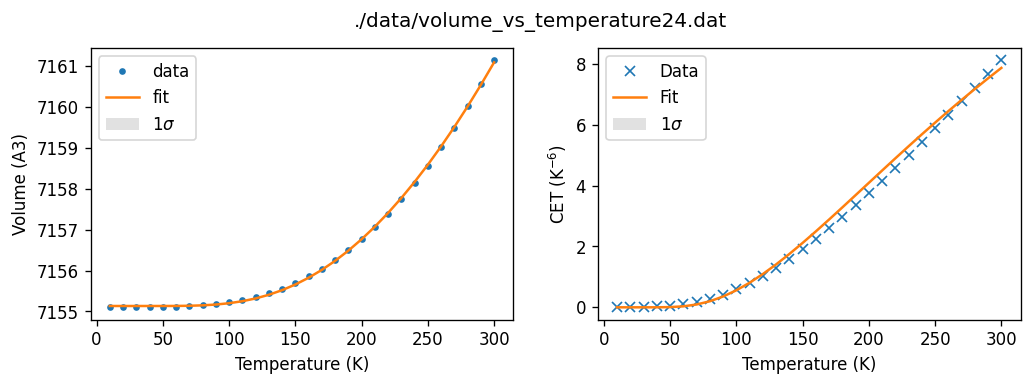

###################### ./data/volume_vs_temperature25.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 35130
    # data points      = 30
    # variables        = 5
    chi-square         = 0.01685143
    reduced chi-square = 6.7406e-04
    Akaike info crit   = -214.535507
    Bayesian info crit = -207.529520
[[Variables]]
    a0:  7147.87282 +/- 0.00871634 (0.00%) (init = 400)
    a1:  579.797714 +/- 47.7916532 (8.24%) (init = 100)
    a2:  0 (fixed)
    a3:  1783.73946 +/- 768.875914 (43.10%) (init = 0)
    a4: -4.87123724 +/- 0.43553909 (8.94%) (init = 0)
    a5:  0.08423024 +/- 0.00553155 (6.57%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.992
    C(a1, a5) =  0.967
    C(a3, a5) =  0.950
    C(a0, a5) =  0.501
    C(a0, a1) =  0.447
    C(a0, a3) =  0.380
Cost: -0.004757405959026073
---------- DE bounds ----------
a0 :         0	     7147.87	    8000
a1 :         0	     

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0015259923762337285 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.946880769273321) = 0.29997142652424813 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.03123  -0.03123  -0.031237147.86891  +0.00781  +0.00781  +0.00781
 a1: -66.85100 -62.83938  -0.81645 523.04091 +34.78495 +72.86451+116.00929
 a3:-356.54820-249.45873-164.175421054.95721 +15.15685 +52.28268 +47.37812
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.01300  -0.00137  -0.00022   0.07761  +0.00294  +0.00324  +0.00134
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 636
    # data points      = 30
    # variables        = 5
    chi-square         = 0.01505491
    reduced chi-square = 6.0220e-04
    Akaike info crit   = -217.917457
    Bayesian info crit = -210.911470
[[Variables]]
    a0:  7147.86891 +/- 0.00780799 (0.00%) (init = 7147.873)
    a1:  523.040908 +/- 33.4777881 (6.40%) (init = 579.7977)
    a2:  0 (fixed)
    a3:  1054.95721 +/- 356.548200 (33.80%) (init = 1783.739)
    a4: -4.99999995 +/- 2.6427e-04 (0.01%) (init

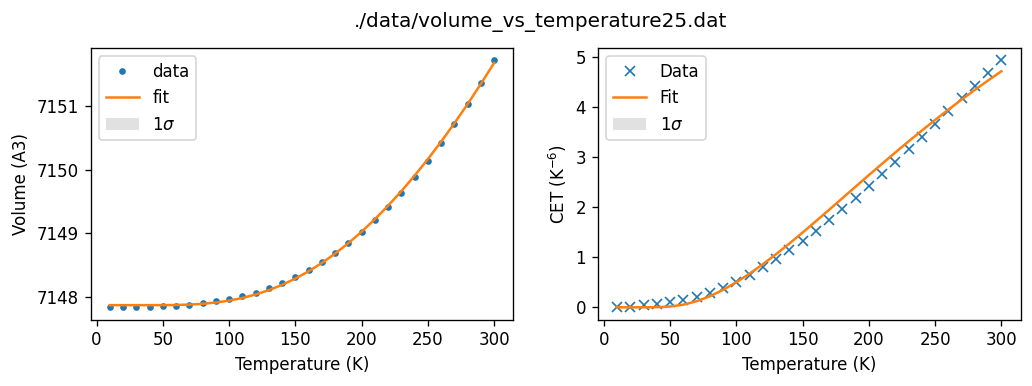

###################### ./data/volume_vs_temperature26.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 30096
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00209976
    reduced chi-square = 8.3991e-05
    Akaike info crit   = -277.013821
    Bayesian info crit = -270.007834
[[Variables]]
    a0:  7172.74389 +/- 0.00277151 (0.00%) (init = 400)
    a1:  656.675108 +/- 24.2083333 (3.69%) (init = 100)
    a2:  0 (fixed)
    a3:  1993.97116 +/- 506.955704 (25.42%) (init = 0)
    a4: -4.78054418 +/- 0.51119739 (10.69%) (init = 0)
    a5:  0.11065556 +/- 0.00390415 (3.53%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.989
    C(a3, a5) =  0.964
    C(a1, a5) =  0.954
    C(a0, a5) =  0.298
    C(a0, a1) =  0.277
    C(a0, a3) =  0.214
    C(a4, a5) = -0.193
    C(a0, a4) =  0.110
Cost: 0.0026243574748150422
---------- DE bounds ----------
a0 :      

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a3=3000) = 0.962051436805831 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.003154165544838949 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.991974253017499) = 0.1312770508780075 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01076  -0.01076  -0.010767172.74359  +0.00807  +0.00807  +0.00807
 a1: -23.14118 -10.68872 -10.90614 647.56653 +23.46325 +47.68671 +56.88145
 a3:-1111.55057-792.82605-419.625111834.83856 +59.59991+1063.36438      +inf
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00375  -0.00375  -0.00149   0.10965  +0.00340  +0.00649  +0.00751
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 669
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00202703
    reduced chi-square = 8.1081e-05
    Akaike info crit   = -278.071356
    Bayesian info crit = -271.065370
[[Variables]]
    a0:  7172.74359 +/- 0.00268966 (0.00%) (init = 7172.744)
    a1:  647.566528 +/- 23.1411752 (3.57%) (init = 656.6751)
    a2:  0 (fixed)
    a3:  1834.83856 +/- 454.646038 (24.78%) (init = 1993.971)
    a4: -5.00000000 +/- 3.9929e-05 (0.00%) (in

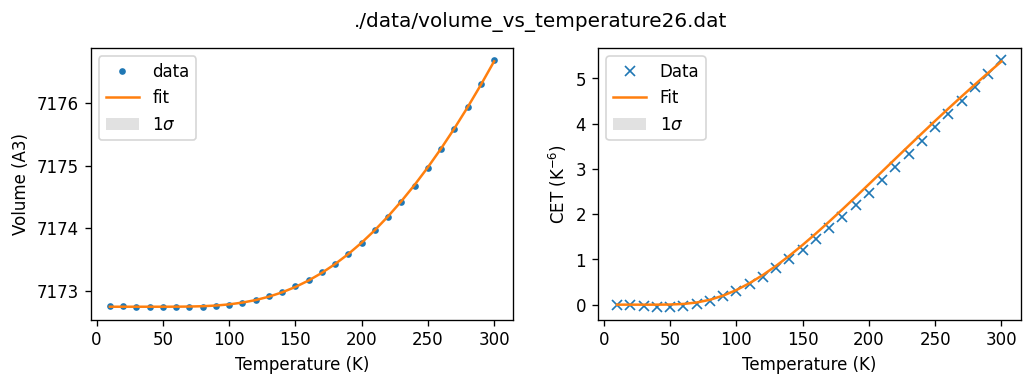

###################### ./data/volume_vs_temperature27.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 26808
    # data points      = 30
    # variables        = 5
    chi-square         = 5.9964e-04
    reduced chi-square = 2.3986e-05
    Akaike info crit   = -314.611132
    Bayesian info crit = -307.605145
[[Variables]]
    a0:  7151.58119 +/- 0.00154049 (0.00%) (init = 400)
    a1:  698.501646 +/- 17.0556258 (2.44%) (init = 100)
    a2:  0 (fixed)
    a3:  1473.41213 +/- 282.143805 (19.15%) (init = 0)
    a4: -3.57489697 +/- 1.55137876 (43.40%) (init = 0)
    a5:  0.10300580 +/- 0.00314128 (3.05%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a5) =  0.867
    C(a1, a3) =  0.792
    C(a4, a5) = -0.620
    C(a1, a4) =  0.440
    C(a1, a5) =  0.425
    C(a0, a4) =  0.418
    C(a0, a1) =  0.265
    C(a3, a4) = -0.193
    C(a0, a5) = -0.145
Cost: 0.002352919430450129
---------- DE bounds

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00020232811009916502 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.002851809245582321 < 1e-05 at iteration 22 and prob(a4=-4.999596483566985) = 0.036867589640769416 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00487  -0.00487  -0.004877151.58076  +0.00487  +0.00487  +0.00487
 a1:  -0.58274 -18.46478 -18.40040 711.95107 +18.84492 +38.08590 +49.83102
 a3:-977.59334-681.13199-357.046981905.09262+363.82485+364.81862+185.95483
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00579  -0.00578  -0.00297   0.10794  +0.00259  +0.00551  +0.00579
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 723
    # data points      = 30
    # variables        = 5
    chi-square         = 4.3461e-04
    reduced chi-square = 1.7385e-05
    Akaike info crit   = -324.267444
    Bayesian info crit = -317.261457
[[Variables]]
    a0:  7151.58076 +/- 0.00121790 (0.00%) (init = 7151.581)
    a1:  711.951075 +/- 18.6981572 (2.63%) (init = 698.5016)
    a2:  0 (fixed)
    a3:  1905.09262 +/- 372.916828 (19.57%) (init = 1473.412)
    a4: -5.00000000 +/- 1.8342e-05 (0.00%) (init

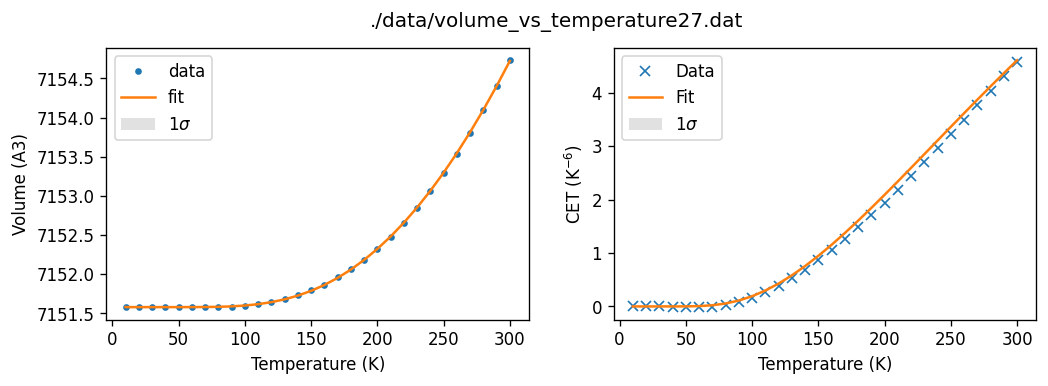

###################### ./data/volume_vs_temperature28.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 37302
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00472169
    reduced chi-square = 1.8887e-04
    Akaike info crit   = -252.703576
    Bayesian info crit = -245.697590
[[Variables]]
    a0:  7157.59474 +/- 0.00406454 (0.00%) (init = 400)
    a1:  617.573734 +/- 20.7466416 (3.36%) (init = 100)
    a2:  0 (fixed)
    a3:  1626.21730 +/- 430.308614 (26.46%) (init = 0)
    a4: -4.95830145 +/- 0.26936631 (5.43%) (init = 0)
    a5:  0.13015458 +/- 0.00444770 (3.42%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.990
    C(a1, a5) =  0.980
    C(a3, a5) =  0.961
    C(a0, a5) =  0.151
Cost: 0.0023927487836772343
---------- DE bounds ----------
a0 :         0	     7157.59	    8000
a1 :         0	     617.574	    2000
a2 :   -150000	           0	 

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.001690890452931322 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.03441828450166628 < 1e-05 at iteration 14 and prob(a4=-4.999668966917611) = 0.02350595263101648 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01598  -0.01598  -0.015987157.59527  +0.01198  +0.01198  +0.01198
 a1: -46.81057 -45.49123 -22.33499 641.43421 +23.94681 +34.65335 +42.54545
 a3:-1396.36632-998.00150-256.572802171.42471+550.45414+577.44593 +48.61342
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.01582  -0.01018  -0.00405   0.13516  +0.00347  +0.00479  +0.00479
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 851
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00450751
    reduced chi-square = 1.8030e-04
    Akaike info crit   = -254.096247
    Bayesian info crit = -247.090260
[[Variables]]
    a0:  7157.59527 +/- 0.00399434 (0.00%) (init = 7157.595)
    a1:  641.434206 +/- 23.4052832 (3.65%) (init = 617.5737)
    a2:  0 (fixed)
    a3:  2171.42471 +/- 579.350986 (26.68%) (init = 1626.217)
    a4: -5.00000000 +/- 2.3645e-05 (0.00%) (ini

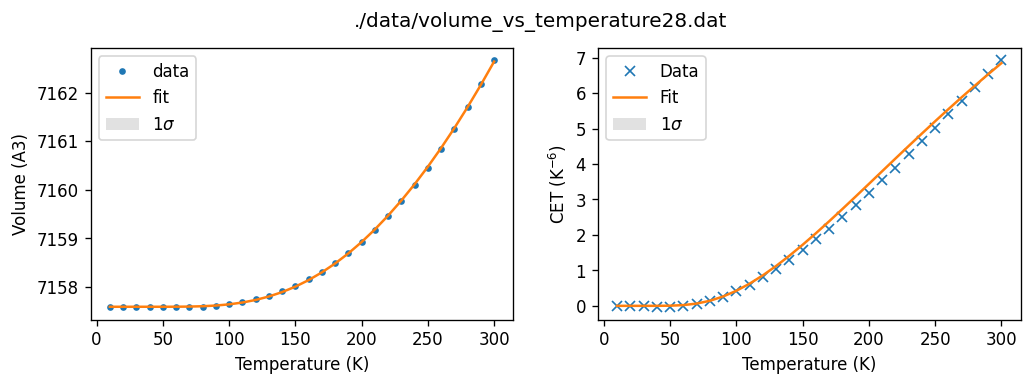

###################### ./data/volume_vs_temperature29.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32832
    # data points      = 30
    # variables        = 5
    chi-square         = 0.01640345
    reduced chi-square = 6.5614e-04
    Akaike info crit   = -215.343837
    Bayesian info crit = -208.337851
[[Variables]]
    a0:  7149.97571 +/- 0.00812300 (0.00%) (init = 400)
    a1:  537.840756 +/- 32.1281732 (5.97%) (init = 100)
    a2:  0 (fixed)
    a3:  1354.24630 +/- 452.213487 (33.39%) (init = 0)
    a4: -4.93610701 +/- 0.40227489 (8.15%) (init = 0)
    a5:  0.09009306 +/- 0.00459101 (5.10%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.983
    C(a1, a5) =  0.965
    C(a3, a5) =  0.942
    C(a0, a5) =  0.311
    C(a0, a1) =  0.252
    C(a0, a3) =  0.151
    C(a1, a4) =  0.104
Cost: 0.0054948079377936665
---------- DE bounds ----------
a0 :         0	     7149.98	    80

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0007697259934008459 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.993350282283469) = 0.10572065920484305 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.03222  -0.03222  -0.032227149.97573  +0.01611  +0.01611  +0.01611
 a1:  -2.24411 -30.80893  -0.72411 528.34267 +32.06132 +66.95996+100.40836
 a3:-850.87717-632.11667-289.806381222.01028+307.77207+400.85909+402.26380
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.01387  -0.00912  -0.00454   0.08901  +0.00145  +0.00049  +0.00905
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 442
    # data points      = 30
    # variables        = 5
    chi-square         = 0.01620995
    reduced chi-square = 6.4840e-04
    Akaike info crit   = -215.699821
    Bayesian info crit = -208.693834
[[Variables]]
    a0:  7149.97573 +/- 0.00805601 (0.00%) (init = 7149.976)
    a1:  528.342666 +/- 30.8089288 (5.83%) (init = 537.8408)
    a2:  0 (fixed)
    a3:  1222.01028 +/- 402.263797 (32.92%) (init = 1354.246)
    a4: -5.00000000 +/- 3.3083e-05 (0.00%) (init

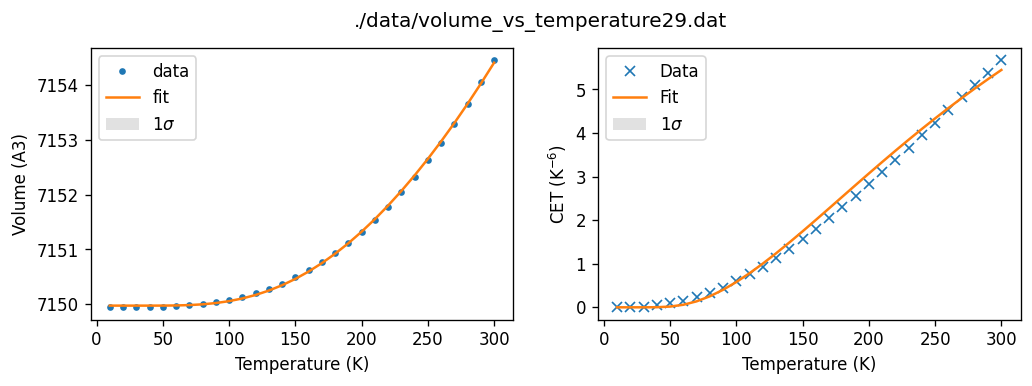

In [2]:
from glob import glob
import numpy as np
from uncertainties import correlated_values
import uncertainties.unumpy as unp
from uncertainties import ufloat


folder = 'data'

for i in range(30):
    
    file = f'./{folder}/volume_vs_temperature{i:02d}.dat'
    
    print('{0:#^80}'.format(' '+str(file)+' '))
            
    M = np.genfromtxt(file)
    temperature = M[:,0]
    volume = M[:,1]
    
    cte_data = CET_numerical(temperature, volume)
    
    result0 = fit_volume_vs_temperature(temperature, volume, cte_data)
    result = second_fit(temperature, volume, cte_data, result0)
    
    has_uncertainties = False
    
    t_fit = np.array(temperature)
    
    if not np.any(np.diag(result.covar) < 0):
        has_uncertainties = True        
    else:
        print('!!!!!!!!!!!!!! Negative variances. Running Nelder-Mead.')
        result = second_fit(temperature, volume, cte_data, result)
        if np.any(np.diag(result.covar) >= 0):
            has_uncertainties = True
    
    
    (a0, a1, a2, a3, a4, a5, a6, a7, a8) = [result.params[k].value for k in result.params.keys()]
    
    if has_uncertainties:
        try:
            (a0, a1, a3, a4, a5) = correlated_values([a0, a1, a3, a4, a5], result.covar)
        except Exception as e:
            print("The execption", e.__class__, "occurred when trying to construct correlated variables a0, a1, a4, a4, a5.")
            print("Ignoring correlation and treating variables as independent")
            a0 = ufloat(a0,np.sqrt(np.diag(result.covar)[0]))
            a1 = ufloat(a1,np.sqrt(np.diag(result.covar)[1]))
            a3 = ufloat(a3,np.sqrt(np.diag(result.covar)[2]))
            a4 = ufloat(a4,np.sqrt(np.diag(result.covar)[3]))
            a5 = ufloat(a5,np.sqrt(np.diag(result.covar)[4]))
        
        v_fit = volume_fcn_unc(t_fit, a0, a1, a2, a3, a4, a5, a6, a7, a8)
        v_nominal = np.array([x.nominal_value for x in v_fit])
        v_unc = np.array([x.std_dev for x in v_fit])
        
        cte_fit = CET_fcn_unc(t_fit, a0, a1, a2, a3, a4, a5, a6, a7, a8)
        cte_nominal = np.array([x.nominal_value for x in cte_fit])
        cte_unc = np.array([x.std_dev for x in cte_fit])
        
        plot_unc(temperature, volume, t_fit, v_nominal, v_unc, cte_data, cte_nominal, cte_unc, file)
        
    else:
        v_nominal = volume_fcn(t_fit,a0, a1, a2, a3, a4, a5, a6, a7, a8)
        v_unc = np.zeros(len(v_nominal))
        
        cte_nominal = CET_fcn_unc(t_fit,a0, a1, a2, a3, a4, a5, a6, a7, a8)
        cte_unc = np.zeros(len(v_nominal))
        
        plot(temperature, volume, t_fit, v_nominal, cte_data, cte_nominal, file)
            
    with open(file.rstrip('dat')+'fit','w') as f:
        f.write('#{T:5}\t{V:10}\t{Vfit:10}\t{Vunc:10}\t{CET:10}\t{CETfit:10}\t{CETunc:10}\n'.format(T='T(K)',V='V(A3)',Vfit='Vfit(A3)',Vunc='Vunc(A3)',CET='CET(1/K)',CETfit='CETfit(1/K)',CETunc='CETunc(1/K)'))
        for i in range(len(temperature)):
            f.write('{T:5.1f}\t{V:10f}\t{Vfit:10f}\t{Vunc:10f}\t{CET: 10e}\t{CETfit: 10e}\t{CETunc: 10e}\n'.format(T=temperature[i],V=volume[i],Vfit=v_nominal[i],Vunc=v_unc[i],CET=cte_data[i],CETfit=cte_nominal[i],CETunc=cte_unc[i]))
    


In [3]:
with open('CET1024.dat','w') as f:
    for i in range(30):
        A = np.genfromtxt(f'./data/volume_vs_temperature{i:02d}.fit')
        cet100 = A[9,5]
        cet300 = A[29,5]
        f.write(f'{i:02d}\t{cet100:0.6e}\t{cet300:0.6e}\n')
    

# New fitting Function

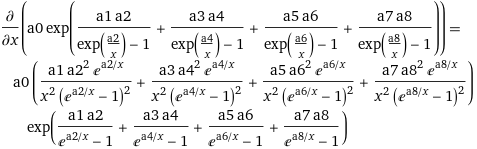

In [9]:

import numpy as np

from lmfit import Parameters, Minimizer, fit_report, conf_interval, report_ci
import matplotlib.pyplot as plt
import uncertainties.unumpy as unp


def volume_fcn2(T, a0, a1, a2, a3, a4, a5, a6, a7, a8):
    x = T/1000
    return a0*np.exp( a1*a2/(np.exp(a2/x)-1)
                     +a3*a4/(np.exp(a4/x)-1)
                     +a5*a6/(np.exp(a6/x)-1)
                     +a7*a8/(np.exp(a8/x)-1))

def CET_fcn2(T, a0, a1, a2, a3, a4, a5, a6, a7, a8):
    x = T/1000
    CTE =   (((a1*a2**2.0*np.exp(a2/x))/((x**2.0)*(np.exp(a2/x)-1)**2.0))
            +((a3*a4**2.0*np.exp(a4/x))/((x**2.0)*(np.exp(a4/x)-1)**2.0))
            +((a5*a6**2.0*np.exp(a6/x))/((x**2.0)*(np.exp(a6/x)-1)**2.0))
            +((a7*a8**2.0*np.exp(a8/x))/((x**2.0)*(np.exp(a8/x)-1)**2.0))
           )/1000
    return CTE

def CET_numerical(T,V):
    #linear extrapolation of volume at T=0
    v0 = V[0]-((V[1]-V[0])/(T[1]-T[0]))*T[0]
    T = np.insert(T, 0, 0.0)
    V = np.insert(V, 0, v0)
    CET = [0.0]
    for i in range(1,len(T)):
        CET.append((1.0/V[i])*(V[i]-V[i-1])/(T[i]-T[i-1]))
    return np.array(CET[1:])

def func2min2(params, T, V, CET):
    parametros = [params[k] for k in params.keys()]
    model_vol = volume_fcn2(T, *parametros)
    residual_vol = model_vol - V  
    return residual_vol

def fit_volume_vs_temperature2(T, V, CET, verbose=True):
    params = Parameters()
    params.add('a0', value=7000, min=0, max=9000, vary=True)
    params.add('a1', value=0.1, min=-50, max=50, vary=True)
    params.add('a2', value=0.01, min=0.001,max=3.5, vary=True)
    params.add('a3', value=0.1, min=-50, max=50, vary=True)
    params.add('a4', value=0.1, min=0.001,max=3.5, vary=True)
    params.add('a5', value=0.1, min=-100, max=100,vary=True)
    params.add('a6', value=1., min=0.001,max=3.5,vary=True)
    params.add('a7', value=0., min=-100, max=100,vary=False)
    params.add('a8', value=1., min=0.001,max=3.5,vary=False)
  
    minimizer = Minimizer(func2min2, params, fcn_args=(T, V, CET))
    out = minimizer.minimize(method='ampgo')#, **kws) 
    fit = func2min2(out.params, T, V,CET)
    if verbose:
        print(fit_report(out), flush=True)
        print('Cost:',np.sum(fit))
        print('---------- DE bounds ----------')
        for k in out.params.keys():
            print('{0:3}:  {1: >8}\t{2: >12.6g}\t{3: >8}'.format(k,out.params[k].min,out.params[k].value,out.params[k].max))
        
    return out

def second_fit2(T,V,CET,out, verbose=True):
    minimizer = Minimizer(func2min2, out.params, fcn_args=(T, V, CET))
    result2 = minimizer.minimize(method='nelder')
    if verbose:
        print(fit_report(result2), flush=True)
    return result2

def plot2(x_data, y_data, x_fit, y_fit, z_data, z_fit, file):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,dpi=120,figsize=(10,3))
    ax1.plot(x_data, y_data, 'o', label='data')
    ax1.plot(x_fit, y_fit, '-',label='fit')
    ax1.set_ylabel('Volume (A3)')
    ax1.set_xlabel('Temperature (K)')
    ax1.legend()
    
    ax2.plot(x_data, 1e6*z_data, 'x',label='Data')
    ax2.plot(x_fit, 1e6*z_fit, label='Fit')
    ax2.set_xlabel('Temperature (K)')
    ax2.set_ylabel('CET (K$^{-6}$)')
    ax2.legend()
    plt.suptitle(file)
    plt.savefig(file.rstrip('dat')+'png')
    plt.show()

###################### ./data/volume_vs_temperature00.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.09193258174309449
Good cost achieved. Stopping. Final cost: 0.09193258174309449


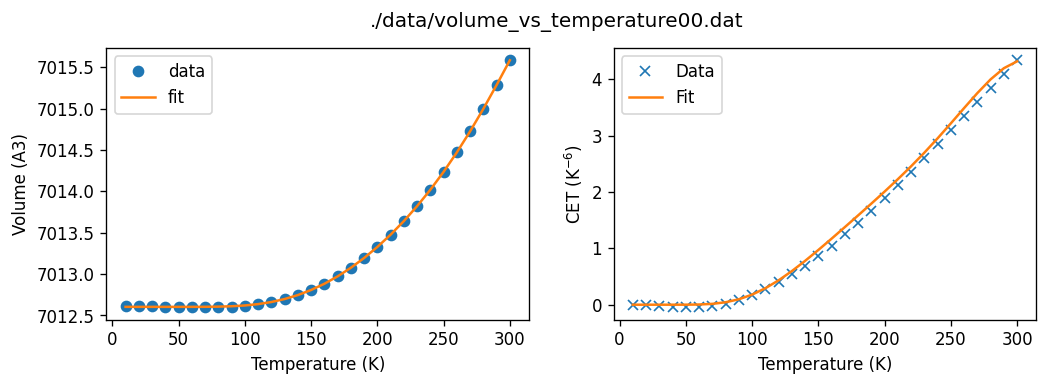

###################### ./data/volume_vs_temperature01.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:1354.9211047799972
Fitting 2


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.1984177575659487
Good cost achieved. Stopping. Final cost: 0.1984177575659487


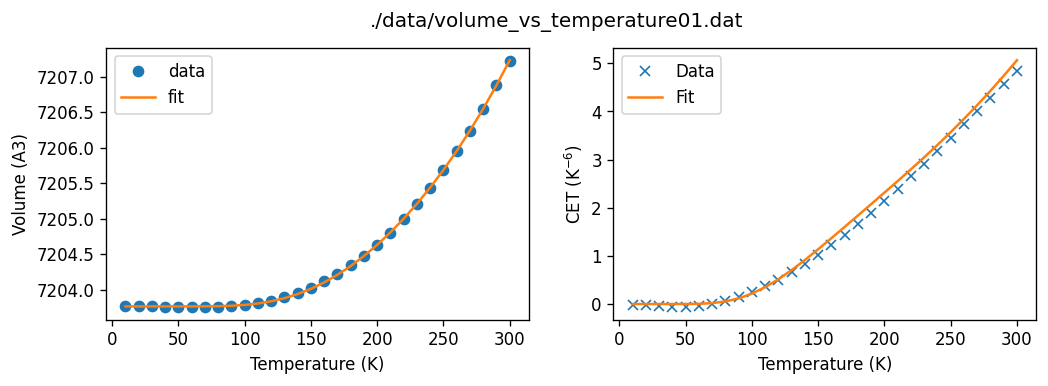

###################### ./data/volume_vs_temperature02.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.17540386321979895
Good cost achieved. Stopping. Final cost: 0.17540386321979895


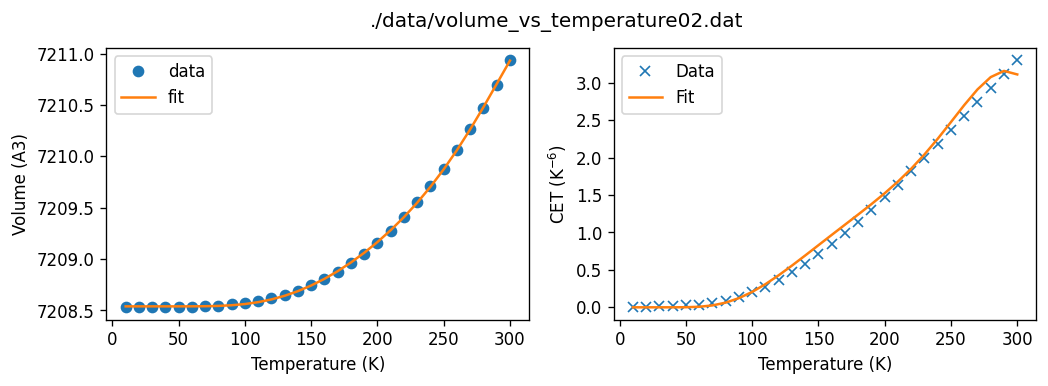

###################### ./data/volume_vs_temperature03.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:854.6194458916243
Fitting 2


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:27.455308952818086
Fitting 3


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


    Better solution found. Cost:5.8701416430731115
Fitting 4


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 5


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


    Better solution found. Cost:1.213406650644174
Fitting 6


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


Fitting 7


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


Fitting 8


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 9


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 10


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Max fittings achieved. Stopping and showing best result. Final cost:10.808525071436634


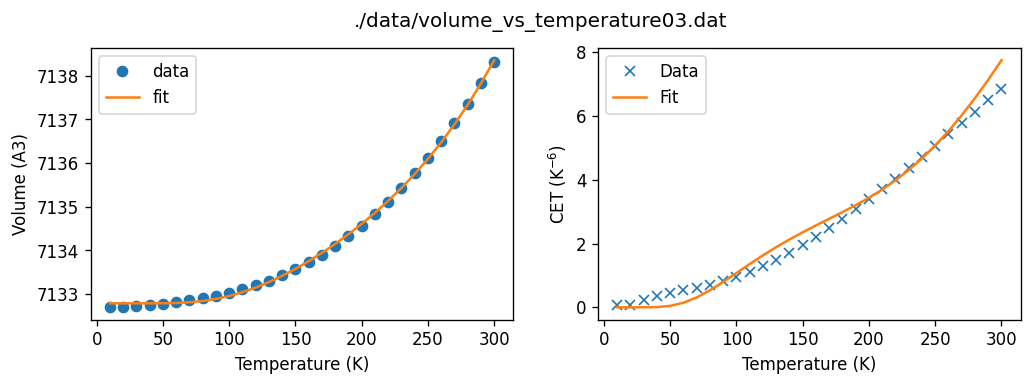

###################### ./data/volume_vs_temperature04.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:16.013543107710575
Fitting 2


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


    Better solution found. Cost:6.346909656817843
Fitting 3


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.24594657332909264
Good cost achieved. Stopping. Final cost: 0.24594657332909264


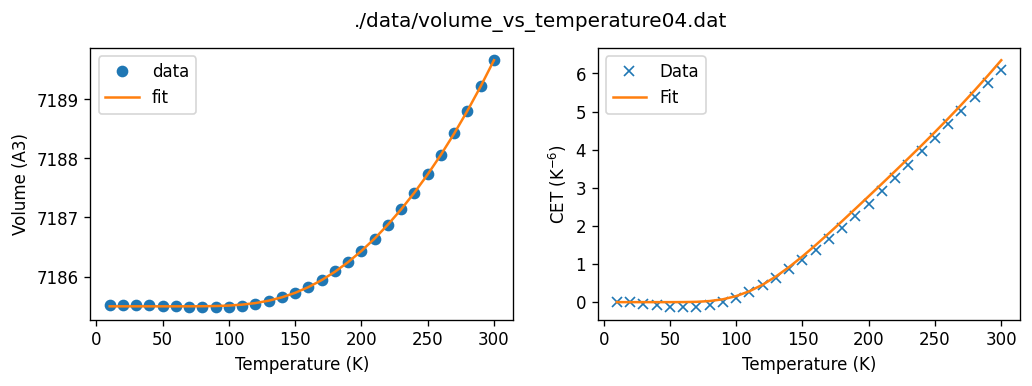

###################### ./data/volume_vs_temperature05.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:4.550991710453673
Fitting 2


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 3


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


Fitting 4


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 5


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 6


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 7


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 8
    Better solution found. Cost:0.132169331298428
Good cost achieved. Stopping. Final cost: 0.132169331298428


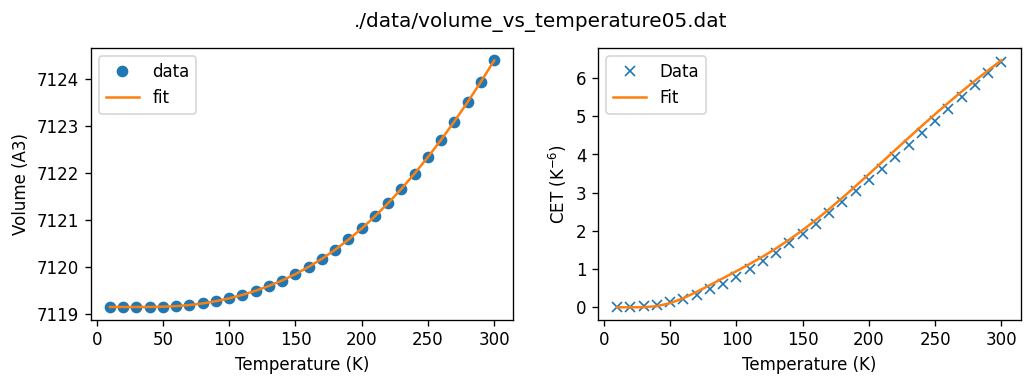

###################### ./data/volume_vs_temperature06.dat ######################
Fitting 1
    Better solution found. Cost:0.03679325332814187
Good cost achieved. Stopping. Final cost: 0.03679325332814187


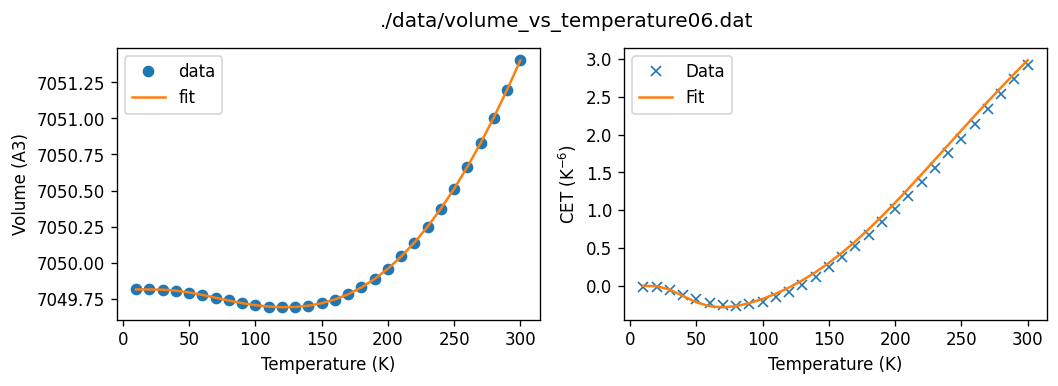

###################### ./data/volume_vs_temperature07.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


    Better solution found. Cost:0.024977274158118234
Good cost achieved. Stopping. Final cost: 0.024977274158118234


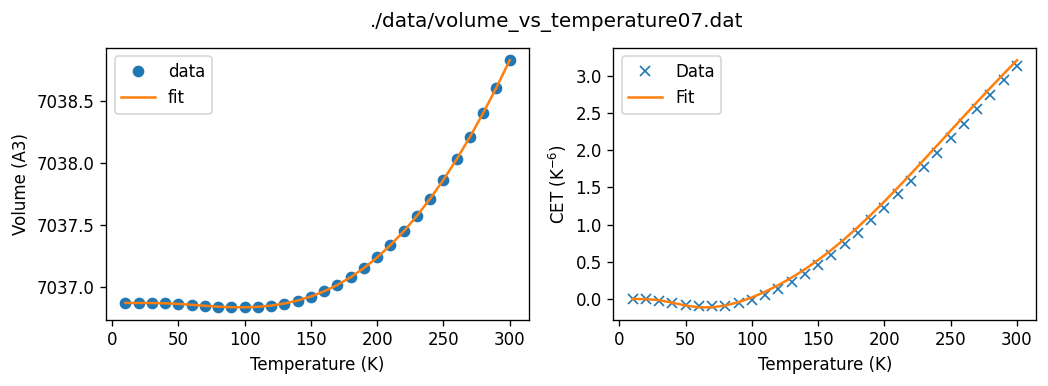

###################### ./data/volume_vs_temperature08.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.07660009086066566
Good cost achieved. Stopping. Final cost: 0.07660009086066566


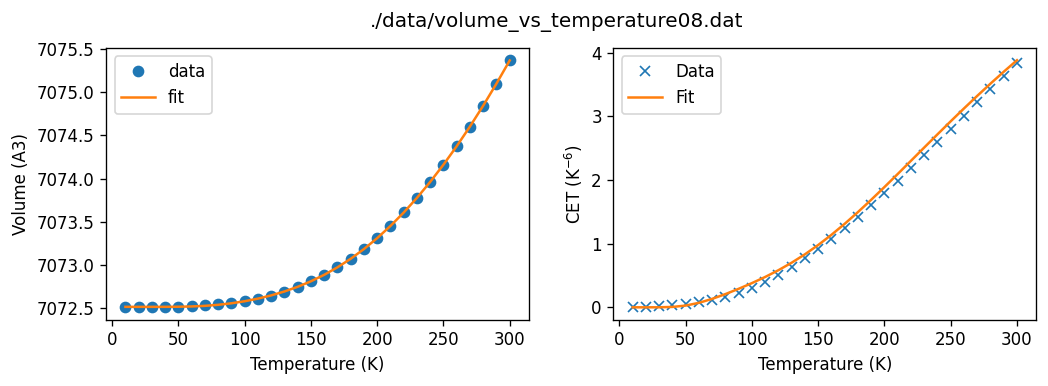

###################### ./data/volume_vs_temperature09.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.09100098986527883
Good cost achieved. Stopping. Final cost: 0.09100098986527883


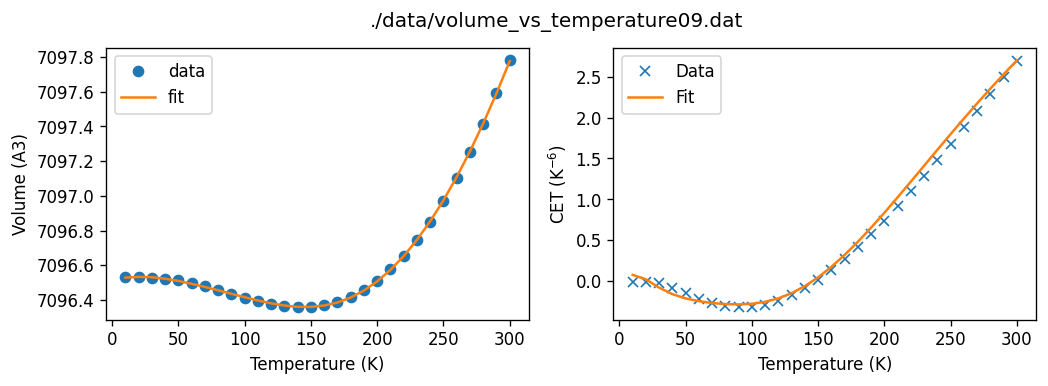

###################### ./data/volume_vs_temperature10.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:4.493466258214539
Fitting 2


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.2942754277601125
Good cost achieved. Stopping. Final cost: 0.2942754277601125


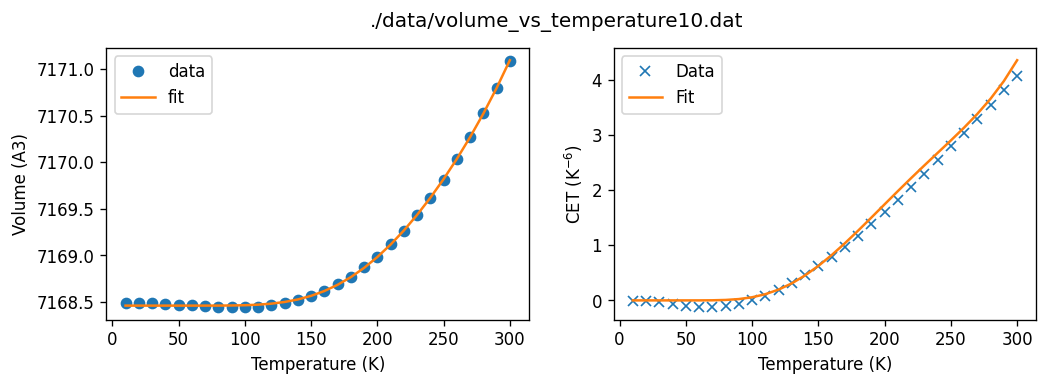

###################### ./data/volume_vs_temperature11.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.08206561482256802
Good cost achieved. Stopping. Final cost: 0.08206561482256802


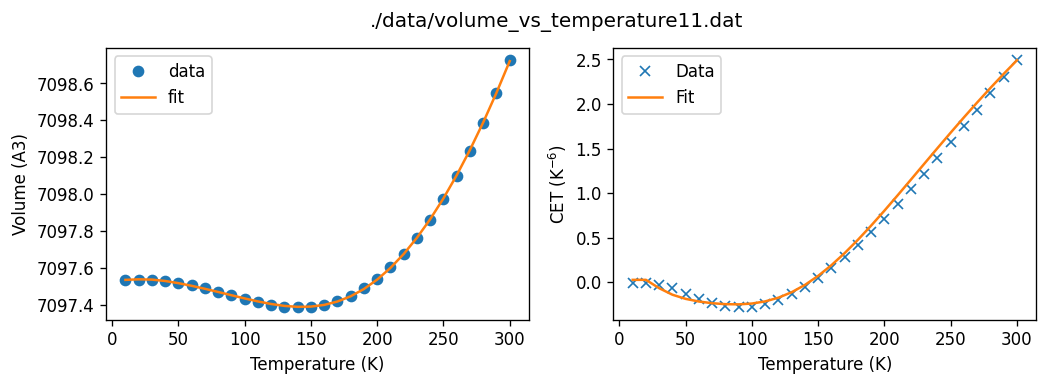

###################### ./data/volume_vs_temperature12.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:4.600460422973811
Fitting 2


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 3


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.15119934697941062
Good cost achieved. Stopping. Final cost: 0.15119934697941062


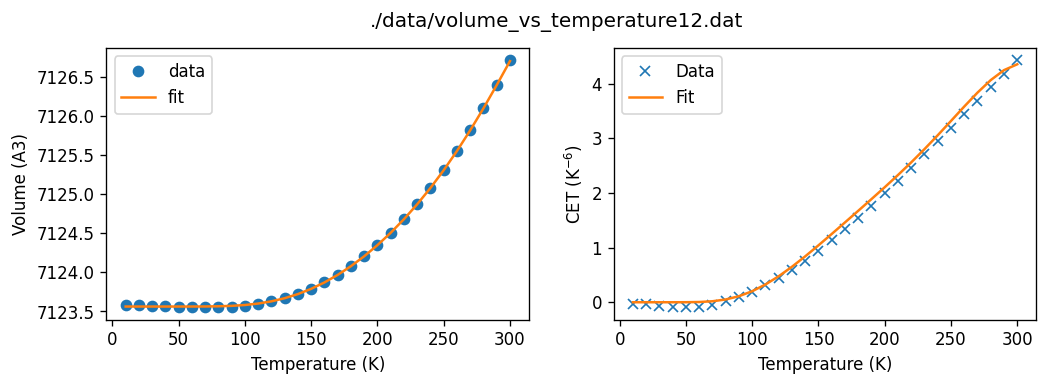

###################### ./data/volume_vs_temperature13.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.3282046350159362
Good cost achieved. Stopping. Final cost: 0.3282046350159362


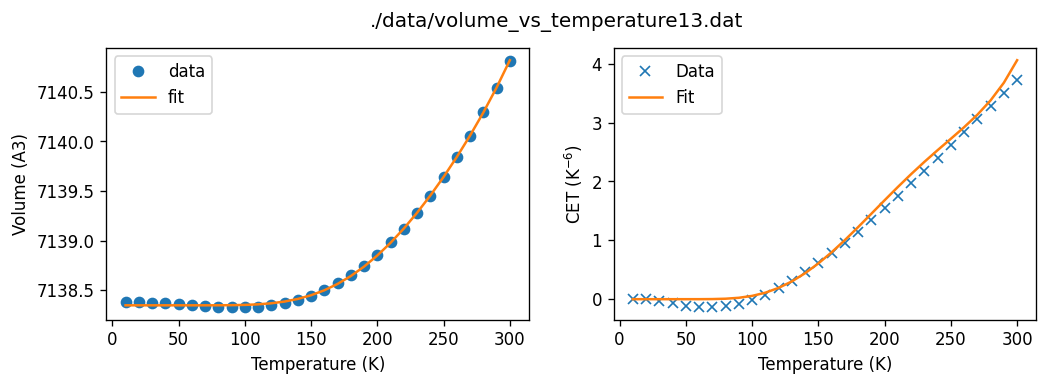

###################### ./data/volume_vs_temperature14.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


    Better solution found. Cost:0.01789246677344636
Good cost achieved. Stopping. Final cost: 0.01789246677344636


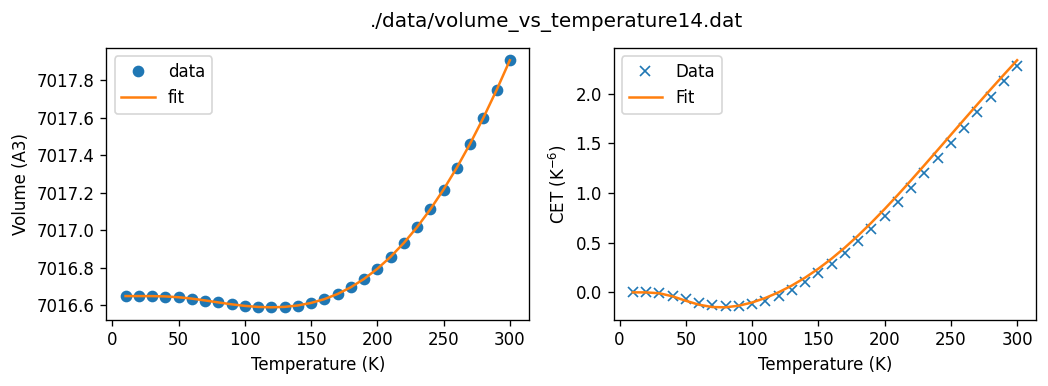

###################### ./data/volume_vs_temperature15.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


    Better solution found. Cost:0.11197194687065348
Good cost achieved. Stopping. Final cost: 0.11197194687065348


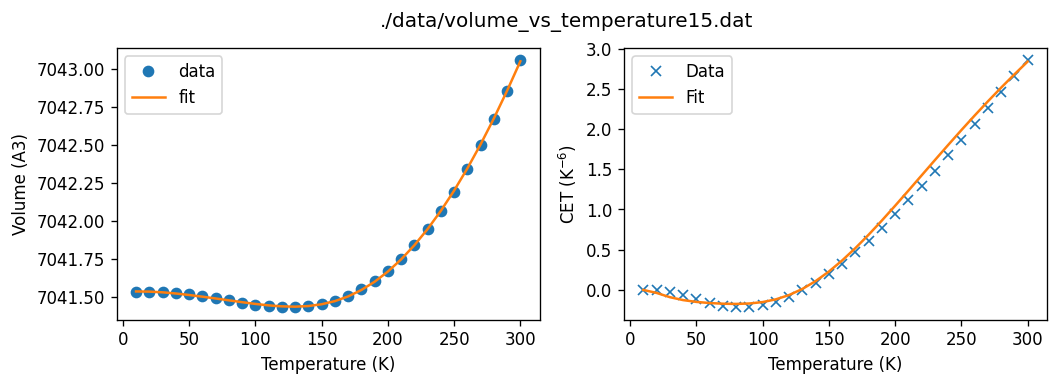

###################### ./data/volume_vs_temperature16.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:3.6146022570301284
Fitting 2
    Better solution found. Cost:0.11295125963533792
Good cost achieved. Stopping. Final cost: 0.11295125963533792


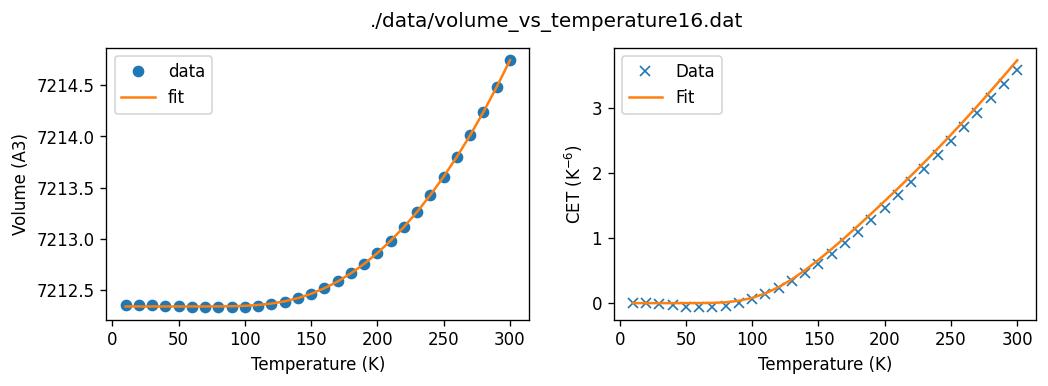

###################### ./data/volume_vs_temperature17.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


    Better solution found. Cost:0.1160488449895638
Good cost achieved. Stopping. Final cost: 0.1160488449895638


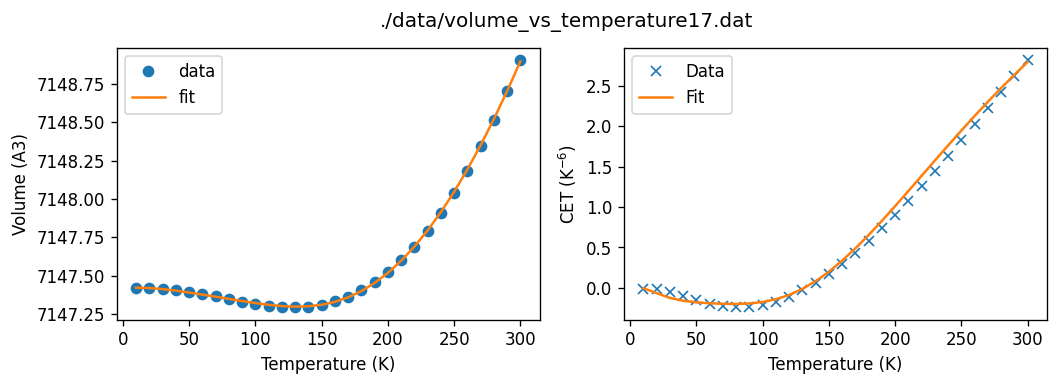

###################### ./data/volume_vs_temperature18.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:7.152735127705455
Fitting 2


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.439395313107525
Good cost achieved. Stopping. Final cost: 0.439395313107525


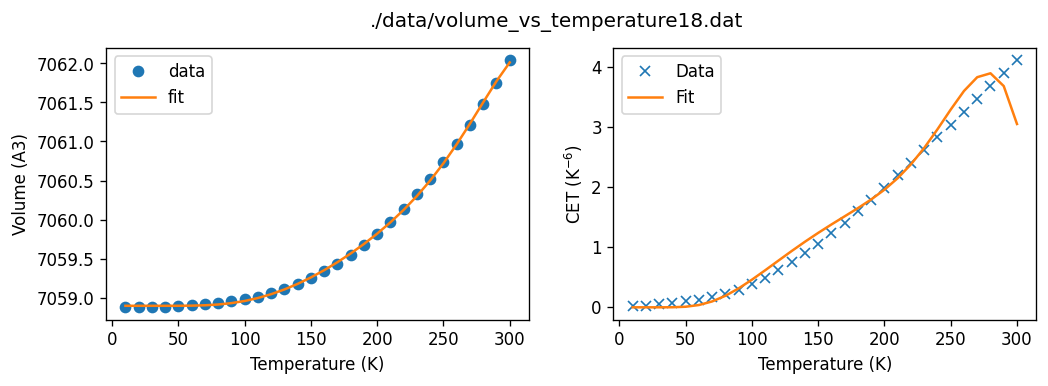

###################### ./data/volume_vs_temperature19.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


    Better solution found. Cost:0.040562332162153325
Good cost achieved. Stopping. Final cost: 0.040562332162153325


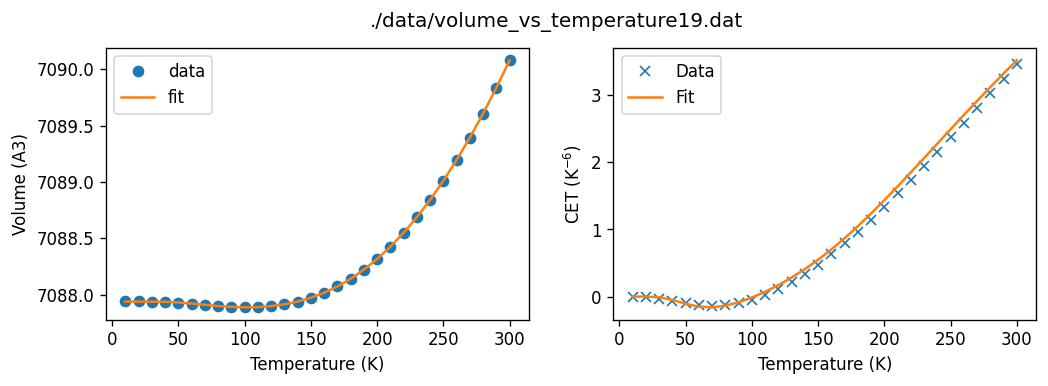

###################### ./data/volume_vs_temperature20.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.1340896446045008
Good cost achieved. Stopping. Final cost: 0.1340896446045008


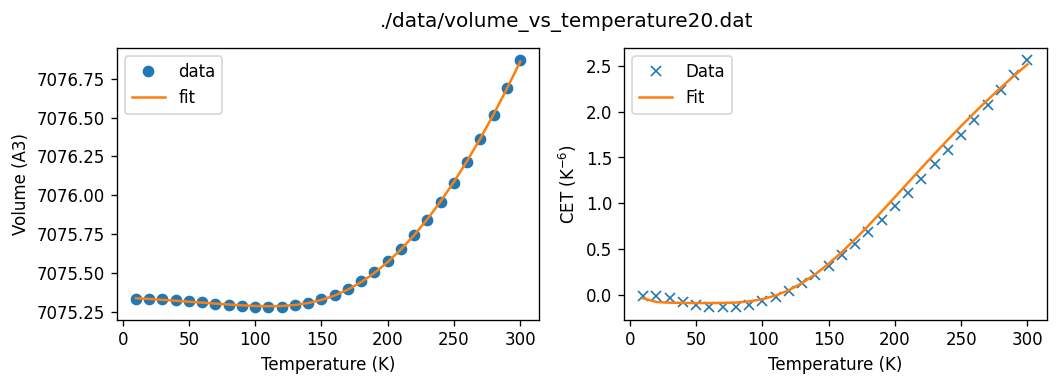

###################### ./data/volume_vs_temperature21.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.28762046059819113
Good cost achieved. Stopping. Final cost: 0.28762046059819113


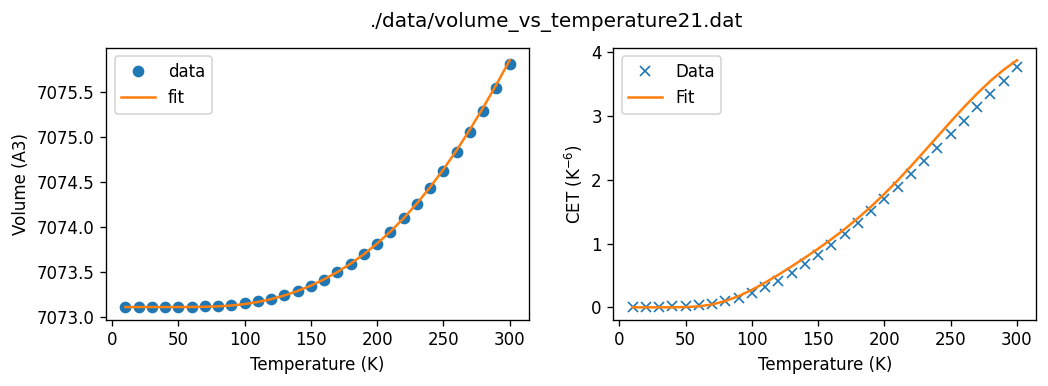

###################### ./data/volume_vs_temperature22.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:8.725797365426843
Fitting 2


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:6.199853616123619
Fitting 3


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:5.724998250707358
Fitting 4


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 5


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 6


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 7


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


    Better solution found. Cost:3.5793583941795077
Fitting 8


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 9


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 10


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Max fittings achieved. Stopping and showing best result. Final cost:6.734072528726756


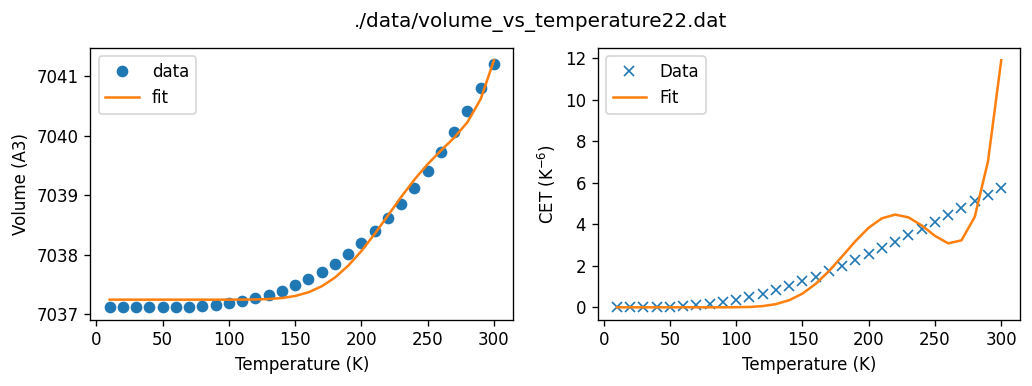

###################### ./data/volume_vs_temperature23.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


    Better solution found. Cost:0.23756632592085225
Good cost achieved. Stopping. Final cost: 0.23756632592085225


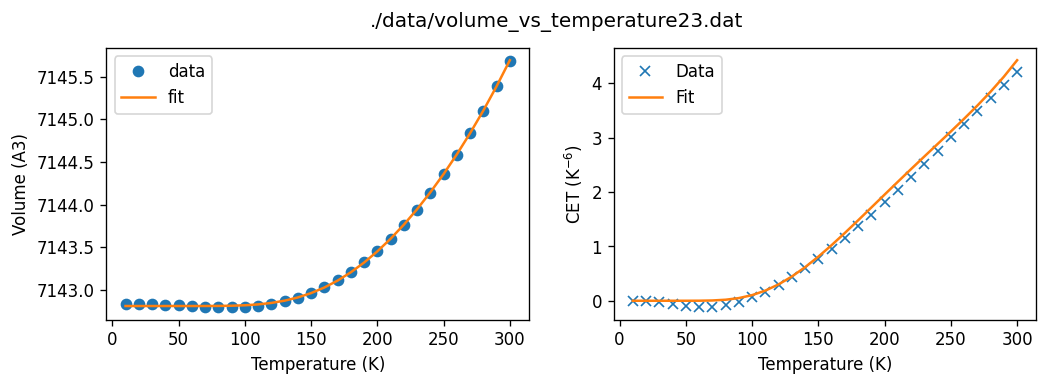

###################### ./data/volume_vs_temperature24.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:12.139545366356288
Fitting 2


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 3


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.866258996000397
Good cost achieved. Stopping. Final cost: 0.866258996000397


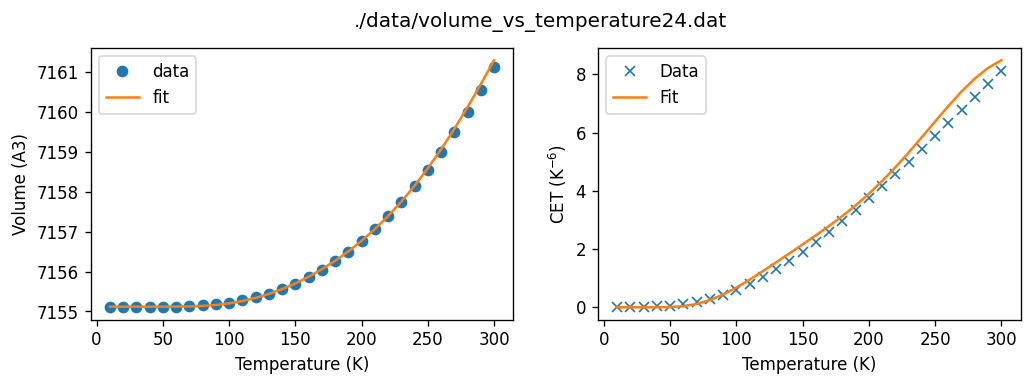

###################### ./data/volume_vs_temperature25.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:2.063282871275078
Fitting 2


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.586084473572555
Good cost achieved. Stopping. Final cost: 0.586084473572555


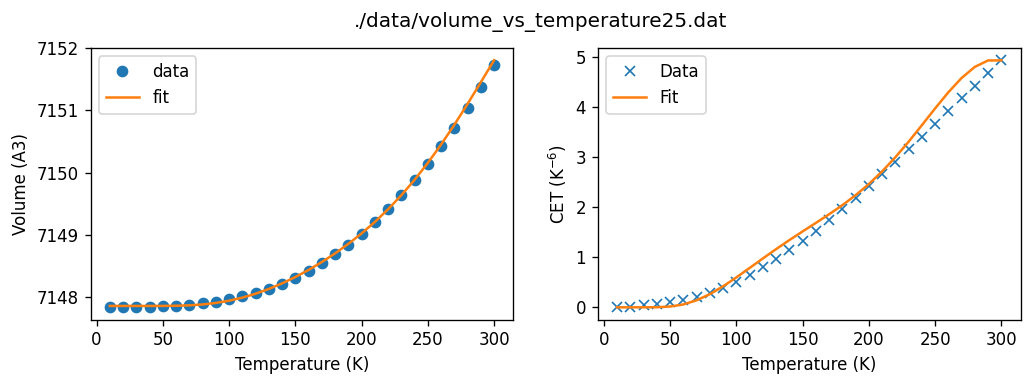

###################### ./data/volume_vs_temperature26.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.04737266588017519
Good cost achieved. Stopping. Final cost: 0.04737266588017519


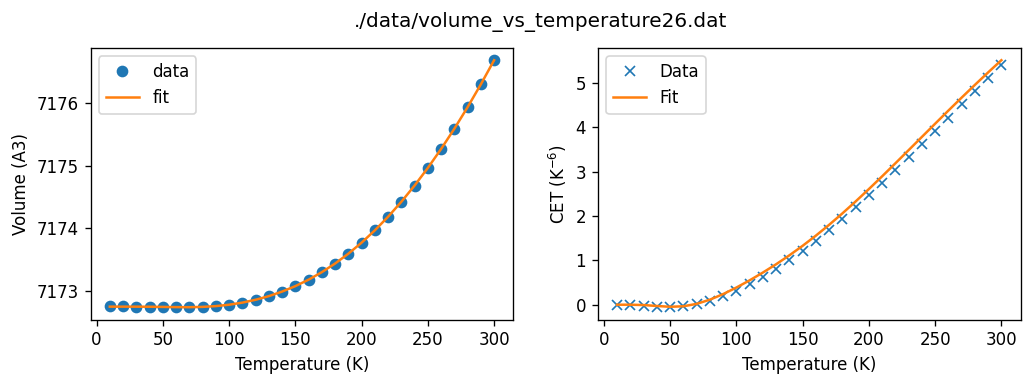

###################### ./data/volume_vs_temperature27.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.0756559755991475
Good cost achieved. Stopping. Final cost: 0.0756559755991475


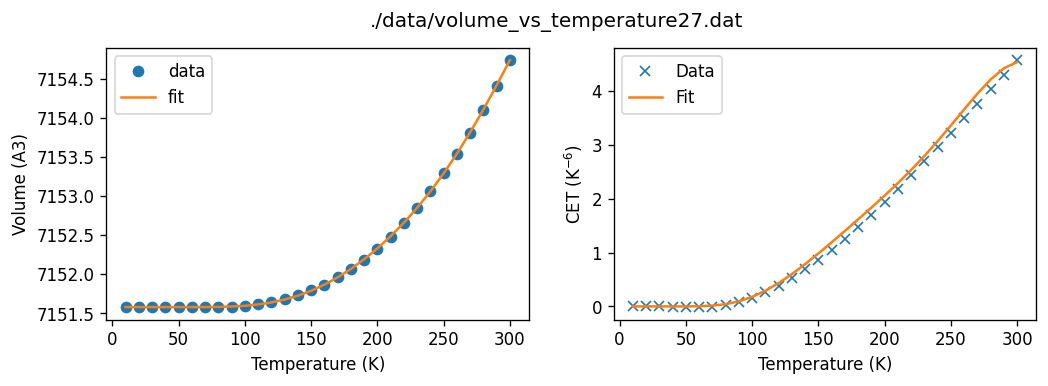

###################### ./data/volume_vs_temperature28.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.215081155281041
Good cost achieved. Stopping. Final cost: 0.215081155281041


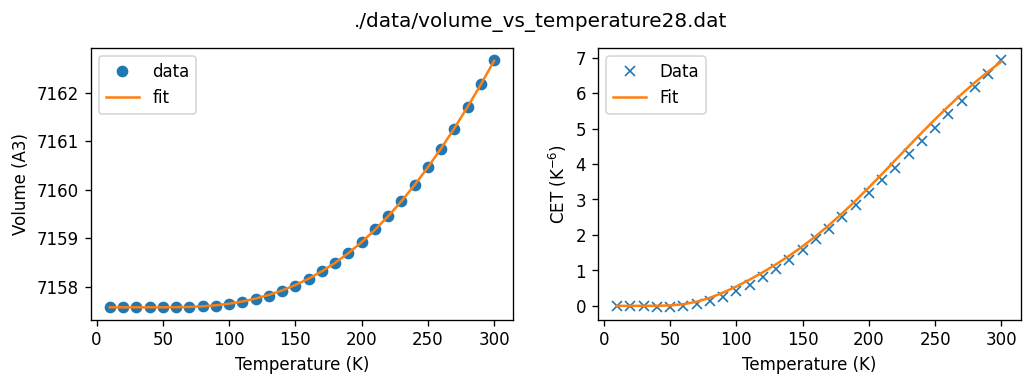

###################### ./data/volume_vs_temperature29.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:6.356659145502817
Fitting 2


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:3.4826125095805764
Fitting 3


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 4


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 5


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 6


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 7


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:1.912930018793304
Fitting 8


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 9


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 10


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Max fittings achieved. Stopping and showing best result. Final cost:11.509175676786981


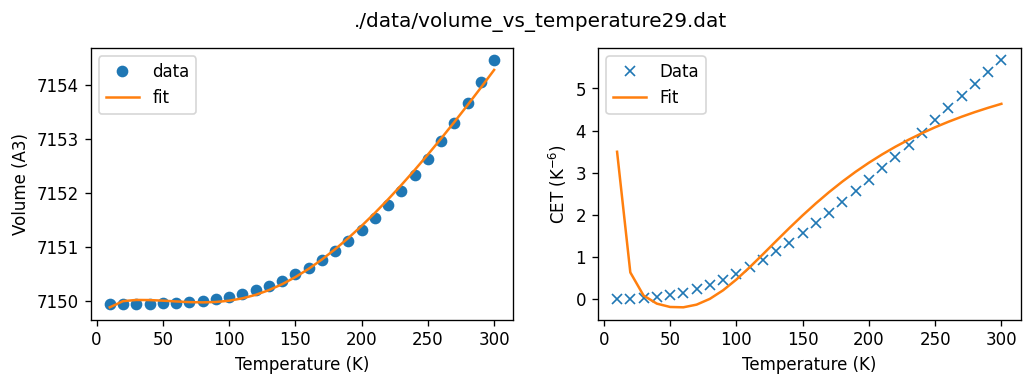

In [14]:
from glob import glob
import numpy as np
from uncertainties import correlated_values
import uncertainties.unumpy as unp
from uncertainties import ufloat

folder = 'data'

for i in range(30):
    file = f'./{folder}/volume_vs_temperature{i:02d}.dat'
    print('{0:#^80}'.format(' '+str(file)+' '))
            
    M = np.genfromtxt(file)
    temperature = M[:,0]
    volume = M[:,1]
    cte_data = CET_numerical(temperature, volume)
    
    #tenta varios fittings até obter um custo baixo ou atingir o maximo de iteracoes
    max_nfits = 10
    best_cost = np.inf
    cost_threshold = 0.5
    cost = 1.0
    for count in range(1,max_nfits+1):
        print(f'Fitting {count}')
        result0 = fit_volume_vs_temperature2(temperature, volume, cte_data, verbose=False)
        result = second_fit2(temperature, volume, cte_data, result0, verbose=False)
        params = [result.params[k].value for k in result.params.keys()]
        cost = np.sum(abs(func2min2(result.params, temperature, volume, cte_data)))
        if cost < best_cost:
            best_cost = cost
            best_params = list(params)
            print(f'    Better solution found. Cost:{cost}')
        if (cost<=cost_threshold):
            print(f'Good cost achieved. Stopping. Final cost: {cost}')
            break
            
    if count == max_nfits:
        print(f'Max fittings achieved. Stopping and showing best result. Final cost:{cost}')
        
    t_fit = np.array(temperature)
    (a0, a1, a2, a3, a4, a5, a6, a7, a8) = (best_params)
    v_nominal = volume_fcn2(t_fit,a0, a1, a2, a3, a4, a5, a6, a7, a8)
    cte_nominal = CET_fcn2(t_fit,a0, a1, a2, a3, a4, a5, a6, a7, a8)
    plot2(temperature, volume, t_fit, v_nominal, cte_data, cte_nominal, file)
    
    v_unc = np.zeros(len(v_nominal))
    cte_unc = np.zeros(len(v_nominal))       
    with open(file.rstrip('dat')+'fit','w') as f:
        f.write('#{T:5}\t{V:10}\t{Vfit:10}\t{Vunc:10}\t{CET:10}\t{CETfit:10}\t{CETunc:10}\n'.format(T='T(K)',V='V(A3)',Vfit='Vfit(A3)',Vunc='Vunc(A3)',CET='CET(1/K)',CETfit='CETfit(1/K)',CETunc='CETunc(1/K)'))
        for i in range(len(temperature)):
            f.write('{T:5.1f}\t{V:10f}\t{Vfit:10f}\t{Vunc:10f}\t{CET: 10e}\t{CETfit: 10e}\t{CETunc: 10e}\n'.format(T=temperature[i],V=volume[i],Vfit=v_nominal[i],Vunc=v_unc[i],CET=cte_data[i],CETfit=cte_nominal[i],CETunc=cte_unc[i]))
    


###################### ./data/volume_vs_temperature03.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:14.438756984391148
Fitting 2


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 3


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:7.518184319345892
Fitting 4


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:3.740933582825164
Fitting 5


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 6


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 7


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.2834717110108613
Good cost achieved. Stopping. Final cost: 0.2834717110108613


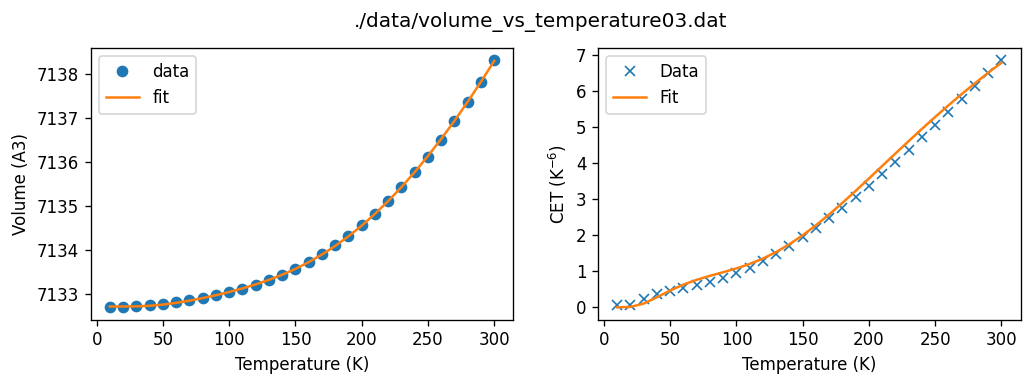

###################### ./data/volume_vs_temperature29.dat ######################
Fitting 1


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:7.939239696894219
Fitting 2


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:4.657006359890147
Fitting 3


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 4


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Fitting 5


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


Fitting 6


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.12346622107997973
Good cost achieved. Stopping. Final cost: 0.12346622107997973


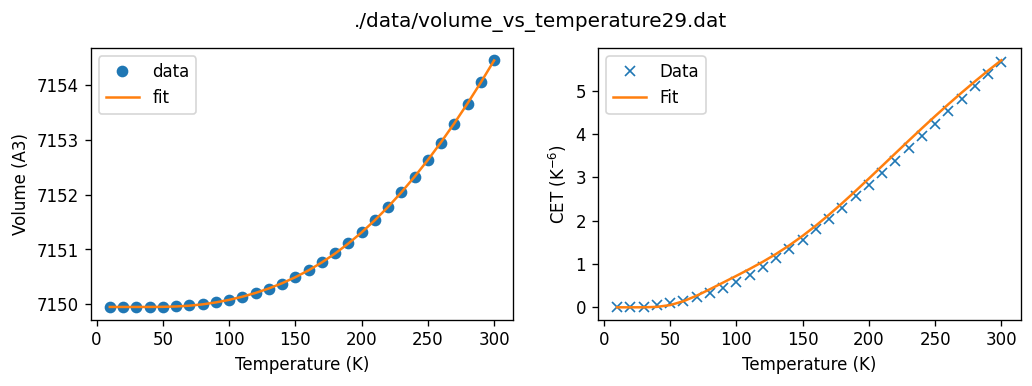

In [15]:
from glob import glob
import numpy as np
from uncertainties import correlated_values
import uncertainties.unumpy as unp
from uncertainties import ufloat

folder = 'data'
redo_list = [3,29]
for i in redo_list:
    file = f'./{folder}/volume_vs_temperature{i:02d}.dat'
    print('{0:#^80}'.format(' '+str(file)+' '))
            
    M = np.genfromtxt(file)
    temperature = M[:,0]
    volume = M[:,1]
    cte_data = CET_numerical(temperature, volume)
    
    #tenta varios fittings até obter um custo baixo ou atingir o maximo de iteracoes
    max_nfits = 10
    best_cost = np.inf
    cost_threshold = 0.5
    cost = 1.0
    for count in range(1,max_nfits+1):
        print(f'Fitting {count}')
        result0 = fit_volume_vs_temperature2(temperature, volume, cte_data, verbose=False)
        result = second_fit2(temperature, volume, cte_data, result0, verbose=False)
        params = [result.params[k].value for k in result.params.keys()]
        cost = np.sum(abs(func2min2(result.params, temperature, volume, cte_data)))
        if cost < best_cost:
            best_cost = cost
            best_params = [result.params[k].value for k in result.params.keys()]
            print(f'    Better solution found. Cost:{cost}')
        if (cost<=cost_threshold):
            print(f'Good cost achieved. Stopping. Final cost: {best_cost}')
            break
            
    if count == max_nfits:
        print(f'Max fittings achieved. Stopping and showing best result. Final cost:{best_cost}')
        
    t_fit = np.array(temperature)
    (a0, a1, a2, a3, a4, a5, a6, a7, a8) = (best_params)
    v_nominal = volume_fcn2(t_fit,a0, a1, a2, a3, a4, a5, a6, a7, a8)
    cte_nominal = CET_fcn2(t_fit,a0, a1, a2, a3, a4, a5, a6, a7, a8)
    plot2(temperature, volume, t_fit, v_nominal, cte_data, cte_nominal, file)
    
    v_unc = np.zeros(len(v_nominal))
    cte_unc = np.zeros(len(v_nominal))       
    with open(file.rstrip('dat')+'fit','w') as f:
        f.write('#{T:5}\t{V:10}\t{Vfit:10}\t{Vunc:10}\t{CET:10}\t{CETfit:10}\t{CETunc:10}\n'.format(T='T(K)',V='V(A3)',Vfit='Vfit(A3)',Vunc='Vunc(A3)',CET='CET(1/K)',CETfit='CETfit(1/K)',CETunc='CETunc(1/K)'))
        for i in range(len(temperature)):
            f.write('{T:5.1f}\t{V:10f}\t{Vfit:10f}\t{Vunc:10f}\t{CET: 10e}\t{CETfit: 10e}\t{CETunc: 10e}\n'.format(T=temperature[i],V=volume[i],Vfit=v_nominal[i],Vunc=v_unc[i],CET=cte_data[i],CETfit=cte_nominal[i],CETunc=cte_unc[i]))
    


In [16]:
with open('CET1024.dat','w') as f:
    for i in range(30):
        A = np.genfromtxt(f'./data/volume_vs_temperature{i:02d}.fit')
        cet100 = A[9,5]
        cet300 = A[29,5]
        f.write(f'{i:02d}\t{cet100:0.6e}\t{cet300:0.6e}\n')
    